# Вступление

В данном проекте мы подробно исследуем недвижимость Санкт-Петербурга и прилежащих к нему населенных пунктов. Нам предоставлен датасет, содержащий информацию об объявлениях площадки Яндекс.Недвижимость. В данном датасете представлены различные признаки, описывающие параметры квартиры и объявления: дата размещения, площадь, стоимость, количество комнат, высоту потолка и т.д.

Мы подробно изучим предоставленные данные, проведем предобработку датасета от пропусков, неявных дубликатов в названиях населенных пунктов, обработаем выбивающиеся значения и рассчитаем дополнительные признаки для квартир.

В основной части работы мы изучим различные параметры квартиры, построим гистограммы распределения этих параметров, посчитаем средние параметры, исследуем, существует ли зависимость цены квартиры от других ее признаков, исследуем как быстро продавались квартиры, постараемся ответить на вопрос, какие продажи можно считать слишком быстрыми или медленными. Так же найдем города с самой высокой стоимостью квадратного метра и самой низкой. В завершении работы мы изучим, как меняется средняя стоимость квартиры в зависимости от ее удаления от центра.

### 1 Изучение общей информации о датасете

#### 1.1. Импорт библиотек, открытие датасета.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import calmap
import scipy

sns.set_style('ticks', {'axes.grid': 'True'})
sns.set_context('notebook')
pd.set_option('display.max_columns', 35) #Увеличиваем количество отображаемых столбцов в одной ячейке

In [3]:
cols_descr_dict = {'total_area':'Общая площадь квартиры, м2',
                   'living_area':'Жилая площадь квартиры, м2',
                   'kitchen_area':'Площадь кухни, м2',
                   'last_price':'Цена квартиры, 10 млн. руб',
                   'rooms':'Количество комнат',
                   'ceiling_height':'Высота потолка, м.',
                   'floor':'Этаж квартиры',
                   'floor_category':'Категория этажа квартиры',
                   'floors_total':'Количество этажей дома',
                   'cityCenters_nearest':'Расстояние до центра города, м.',
                   'cityCenters_nearest_km':'Расстояние до центра города, км.',
                   'airports_nearest':'Расстояние до ближайшего аэропорта, м.',
                   'parks_nearest':'Расстояние до ближайшего парка, м.',
                   'ponds_nearest':'Расстояние до ближайшего водоема, м.', 
                   'balcony':'Количество балконов',
                   'ponds_around3000':'Количество прудов в 3 км.',
                   'parks_around3000':'Количество парков в 3 км.',
                   'days_exposition':'Дней до снятия объявления',
                   'total_images':'Количество фотографий',
                   'total_area_cut':'Общая площадь квартиры, м2',
                   'living_area_cut':'Жилая площадь квартиры, м2',
                   'kitchen_area_cut':'Площадь кухни, м2',
                   'weekday':'День недели',
                   'month':'Месяц',
                   'year':'Год'
}
    
def nan_columns_list(df, threshold=0.05):
    '''Функция принимает на вход датафрейм и пороговое значение threshold (по умолчанию 0.05) 
       Печатает информацию о пропусках в столбцах
       Возвращает список названий столбцов, где количество пропусков меньше чем пороговое значение'''
    
    nan_columns = {x: df[x].isna().sum()/len(df) for x in df.columns if df[x].isna().sum() != 0}
    if len(nan_columns) > 0:
        print(f'Пропуски содержатся в {len(nan_columns)} столбцах:')
    else:
        print('Пропуски в датасете отсуствуют!')
    for column, value in nan_columns.items():
        print(f'{value:<6.2%} |пропусков в столбце| {column}')
        
    return [x for x in nan_columns if nan_columns[x] < threshold]

def whiskers(df, col):
    '''Функция принимает на вход датафрейм и столбец
       Вычисляет большее и меньшее значение "усов" boxplot-а
       Проверяет, чтобы значения не были больше/меньше соответственных значений датафрейма
       Возвращает кортеж из значений high_value и low_value'''
    
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    high_value = df[col].quantile(0.75) + iqr
    low_value = df[col].quantile(0.25) - iqr
    
    if high_value > df[col].max():
        high_value = df[col].max()
    if low_value < df[col].min():
        low_value = df[col].min()
        
    return (high_value, low_value)

def objects_in_iqr(df, col):
    '''Функция принимает на вход датафрейм и столбец
       Вычисляет количество объектов внутри межквартильного размаха и снаружи
       Возвращает количества объектов внутри и снаружи iqr'''
    right, left = whiskers(df, col)
    inside_iqr = len(df[(df[col] >= left) & (df[col] <= right)])
    outside_iqr = len(df) - inside_iqr
    
    return inside_iqr, outside_iqr


def splitter(row):
    '''Функция разбивает переданную в нее строчку на две подстроки
       При этом одна из подстрок будет только нижнего регистра, другая только верхнего
       Возвращает строку нижнего и верхнего регистра в виде кортежа'''
    lower_lst = []
    capitalized_lst = []
    for i in row.split():
        if i.islower():
            lower_lst.append(i)
        elif i.istitle:
            capitalized_lst.append(i)
            
    return ' '.join(lower_lst), ' '.join(capitalized_lst)

def draw_boxplot(df, col):
    '''Функция рисует боксплот для переданного в нее датафрейма и столбца
       Вычисляет значения левого уса, правого уса, медианы, количество объектов внутри iqr и снаружи'''
    color='dodgerblue'
    right_wh, left_wh = whiskers(df, col)
    median = df[col].median()
    inside_wh, outside_wh = objects_in_iqr(df, col)
    
    sns.boxplot(x=col, data=df, color=color, linewidth=1, width = 0.5, fliersize=2)
    plt.xlim(left_wh - 0.5*left_wh, 3*right_wh)
    plt.title(col)
    plt.text(right_wh, -0.3, f'Левый ус: {round(left_wh,2)}\nПравый ус: {round(right_wh,2)}\nМедиана: {median}')
    plt.text(right_wh, 0.4, f'Внутри iqr: {inside_wh}\nСнаружи iqr: {outside_wh}\nВсего: {len(df)}')
    plt.xlabel(cols_descr_dict.get(col))

def draw_three_boxplots(df, columns_to_draw):
    '''Функция рисует 3 боксплота в одном с помощью сабплотов'''
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))
    for i, col in enumerate(columns_to_draw):
        plt.subplot(1,3,i+1)
        draw_boxplot(df,col)
        
def min_max_by_std(df, col):
    '''Функция вычисляет доверительный интервал'''
    mean = df[col].mean()
    std = df[col].std()
    max_value = mean + 3*std
    min_value = mean - 3*std
    return min_value, max_value

def draw_hist(df, col, bins='auto', xlim=None, xticks=None, figsize=(10,6), kde=False):
    '''Функция рисует гистограмму, вычисляет медиану, среднее, размах'''
    color='dodgerblue'
    mean = round(df[col].mean(), 2)
    median = round(df[col].median(), 2)
    max_df = round(df[col].max(), 2)
    min_df = round(df[col].min(), 2)
    range_df = round(df[col].max() - df[col].min())
    
    if figsize != None:
        plt.figure(figsize=figsize)
    else:
        pass
    
    sns.histplot(x=col, data=df, bins=bins, kde=kde, color=color)
    plt.xlim(xlim)
    plt.xticks(xticks)
    
    plt.title(f'Признак: {col}\nСреднее: {mean}\nМедиана: {median}\nРазмах: {range_df}\nМакс.: {max_df}\nМин.: {min_df}', 
              y=0.7, loc='right')
    
    plt.ylabel('Количество наблюдений')
    plt.xlabel(cols_descr_dict.get(col))
    
def draw_count(df, col, xlim=None, xticks=None, figsize=(10,6)):
    '''Функция рисует гистограмму для категориальной переменной'''
    color='dodgerblue'
    median = round(df[col].median(), 2)
    plt.figure(figsize=figsize)
    sns.countplot(x=col, data=df,color=color)
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.title(f'Признак: {col}\nМедиана: {median}', y=0.9, loc='right')
    plt.ylabel('Количество наблюдений')
    plt.xlabel(cols_descr_dict.get(col))

In [4]:
raw_data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

#### 1.2. Изучение общей информации о датасете.

Выведем наш датасет и изучим, какая информация содержится в нем.

In [5]:
raw_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Всего в датафрейме содержится 23699 строк, 22 столбца, 4 разных типа данных: int, float, bool и object. Индексы датафрейма стандартные от 0 до 23698. При беглом просмотре, обнаруживается **большое количество пропусков в столбцах**, исправлением этой проблемы займемся во второй части проекта, во время предобработки.

Подробнее про информацию, заключенную в наши признаки:
1.  total_images  **int** — число фотографий квартиры в объявлении
2.  last_price — **float** — цена на момент снятия с публикации
3.  total_area — **float** — общая площадь квартиры в квадратных метрах (м²)
4.  first_day_exposition — **object** — дата публикации
5.  rooms — **int** — число комнат
6.  ceiling_height — **float** — высота потолков (м)
7.  floors_total — **float** — всего этажей в доме
8.  living_area — **float** — жилая площадь в квадратных метрах (м²)
9.  floor — **int** — этаж
10. is_apartment — **object** — апартаменты
11. studio — **bool** — квартира-студия
12. open_plan — **bool** — свободная планировка
13. kitchen_area — **float** — площадь кухни в квадратных метрах (м²)
14. balcony — **float** — число балконов
15. locality_name — **object** — название населённого пункта
16. airports_nearest — **float** — расстояние до ближайшего аэропорта в метрах (м)
17. cityCenters_nearest — **float** — расстояние до центра города (м)
18. parks_around3000 — **float** — число парков в радиусе 3 км
19. parks_nearest — **float** — расстояние до ближайшего парка (м)
20. ponds_around3000 — **float** — число водоёмов в радиусе 3 км
21. ponds_nearest — **float** — расстояние до ближайшего водоёма (м)
22. days_exposition — **float** — сколько дней было размещено объявление (от публикации до снятия)

Так же во время предобработки необходимо будет **изменить тип данных столбцов**:
* first_day_exposition - изменить тип данных на **datetime**
* floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - на **int**
* is_apartment - на **bool**

Узнаем, какие населенные пункты представлены в датасете:

In [7]:
raw_data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Большое количество населенных пунктов! Все это объявления из Санкт-Петербурга и окресностей, ближайших поселков, деревень и пр. Среди данных населенных пунктов могут встречаться неявные дубликаты, например "посёлок городского типа Красный Бор" и "поселок городского типа Красный Бор", эти неявные дубликаты необходимо будет исправить.

In [8]:
100*len(raw_data.query('locality_name == "Санкт-Петербург"'))/len(raw_data)

66.3361323262585

66% процентов всех объявлений приходится на Санкт-Петербург

Выведем основные статистические показатели датасета:

In [9]:
raw_data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Мы можем заметить, что во всей таблице нам не встречаются отрицательные значения, как и должно быть, но присутствуют неправдоподбные значения, например квартиры с высотой потолка равной 100 метров, очень маленькие значения жилой площади (2 кв. метра) и т.д.

Стоит отметить, что почти во всех столбцах значения среднего и медианы лежат довольно близко друг к другу, это говорит нам о том, что в данных нет большого числа выбросов или их влияние не столь велико.

Рассмотрим гистограммы наших количественных переменных, разделим их на номинативные и непрервные и построим гистограммы отдельно.
К номинативным переменным относятся столбцы rooms, balcony, parks_around3000 и ponds_around3000, к непрерывным - все остальные числовые переменные.

In [10]:
nominative_num_features = ['rooms', 'balcony', 'parks_around3000', 'ponds_around3000']
continuous_num_features = list({x for x in raw_data.describe().columns} - set(nominative_num_features))

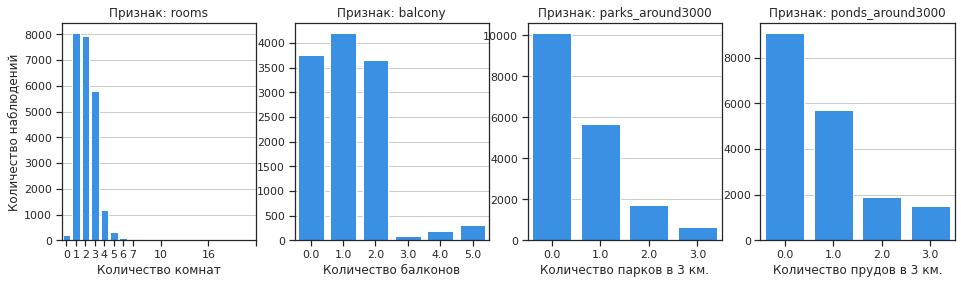

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16,4))
for i, feature in enumerate(nominative_num_features):
    plt.subplot(1,4,i+1)
    sns.countplot(x=feature, data=raw_data, color = 'dodgerblue')
    plt.xlabel(cols_descr_dict.get(feature))
    plt.title(f'Признак: {feature}')
    if i == 0:
        plt.ylabel('Количество наблюдений')
    else:
        plt.ylabel('')
        
    if feature == 'rooms':
        plt.xticks([0,1,2,3,4,5,6,7,10,15,20])

* Количество комнат распределилось логично, больше всего однокомнатных и двухкомнатных квартир, трехкомнатных и более - меньше. Так же присутствуют квартиры с 0 комнатами, они могли появиться из-за невнимательности пользователей или в по другой причине (квартиры студии, квартиры с открытой планировкой).
* Больше всего квартир с 1 балконом, примерно одинаковое количество квартир без балконов и с 2 балконами, присутствуют так же квартиры с 3 и более балконами, ошибка это или действительно так - по сухим данным разобраться без пояснения невозможно.
* В порядке убывания расположилось количество квартир с парками и прудами в радиусе 3 км. Все логично.

Более подробно изучим аномальные значения во второй части проекта.

И построим гистограммы остальных числовых переменных:

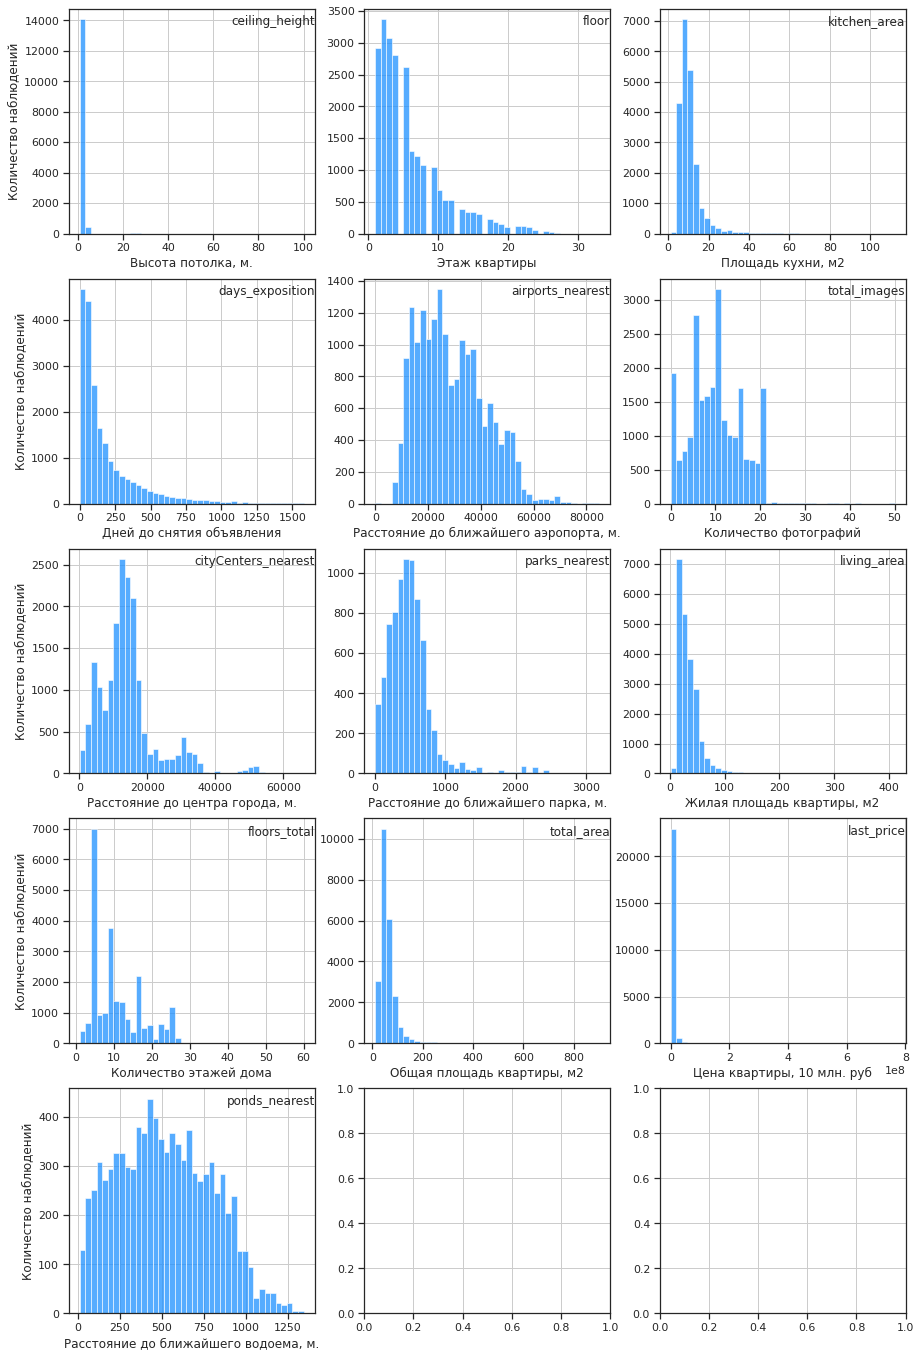

In [12]:
fig, axes = plt.subplots(nrows = ceil(len(continuous_num_features)/3), ncols = 3, figsize=(15,24))
for i, feature in enumerate(continuous_num_features):
    plt.subplot(ceil(len(continuous_num_features)/3),3,i+1)
    sns.histplot(raw_data[feature], bins = 40, color = 'dodgerblue', kde=False)
    plt.xlabel(cols_descr_dict.get(feature))
    plt.title(feature, y=0.9, loc='right')
    if i in (0,3,6,9,12):
        plt.ylabel('Количество наблюдений')
    else:
        plt.ylabel('')

Гистограммы высоты потолка, цен квартир, общей площади и жилой площади в автоматическом масштабе получились малоинформативными, построим их отдельно ниже.

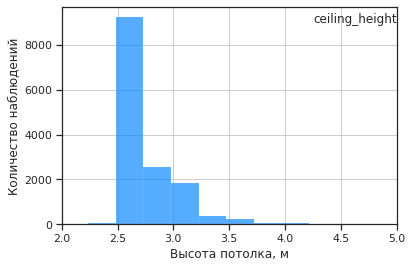

In [13]:
sns.histplot(raw_data['ceiling_height'], bins=400, color='dodgerblue')
plt.xlim(2,5)
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество наблюдений')
plt.title('ceiling_height', y=0.9, loc='right')
plt.show()

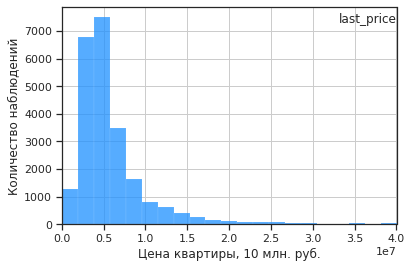

In [14]:
sns.histplot(raw_data['last_price'], bins=400, color='dodgerblue')
plt.xlim(0, 4e7)
plt.xlabel('Цена квартиры, 10 млн. руб.')
plt.ylabel('Количество наблюдений')
plt.title('last_price', y=0.9, loc='right')
plt.show()

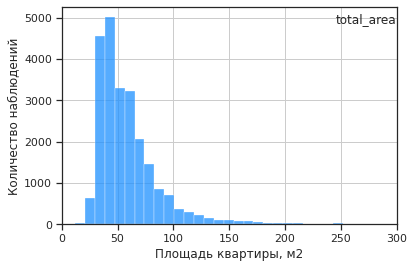

In [15]:
sns.histplot(raw_data['total_area'], bins=100, color='dodgerblue')
plt.xlim(0,300)
plt.xlabel('Площадь квартиры, м2')
plt.ylabel('Количество наблюдений')
plt.title('total_area', y=0.9, loc='right')
plt.show()

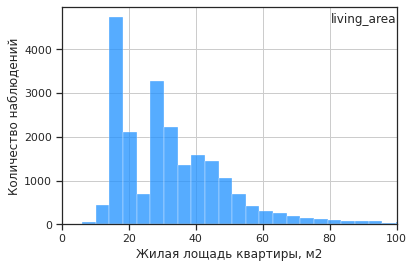

In [16]:
sns.histplot(raw_data['living_area'], bins=100, color='dodgerblue')
plt.xlim(0,100)
plt.xlabel('Жилая лощадь квартиры, м2')
plt.ylabel('Количество наблюдений')
plt.title('living_area', y=0.9, loc='right')
plt.show()

Пойдем по порядку:
1. **kitchen_area** - площадь кухни имеет ярко выраженную моду, равную 10 кв. метрам, впринципе это стандартная средняя кухня в РФ. Не мало кухонь с площадью до 10 кв. метров, это скорее всего хрущевки, более 10 кв. метров - скорее всего новые дома/дома с перепланировкой.
2. **airports_nearest** - расстояние до ближайшего аэропорта, распределение отдаленно напоминает нормальное, большинство квартир расположилось в 20-40 км. от аэропорта
3. **last_price** - цены на квартиры имеют выраженную ассиметрию, больше всего квартир стоят от 2 до 8 млн. руб, есть квартиры дешевле 1 млн. руб.
4. **living_area** - имеет два пика, один до 20 кв. метров и другой примерно на 30 кв. метрах. - это скорее всего выделяются однокомнатные квартиры/студии, а второй пик - двухкомнатные квартиры.
5. **parks_nearest** - большая часть квартир расположилась рядом с парками, ярко выраженный скос.
6. **floors_total** - очень заметно большое количество пятиэтажных домов и девятиэтажных домов, это вполне логично, чем больше этажей - тем меньше наблюдений.
7. **total_images** - количество фотографий, чаще всего пользователи останавливаются на 10 фотографиях. 50 фотографий - скорее всего максимум, который позволяет загрузить площадка.
8. **floor** - больше всего объявлений с продажей квартир на низких этажах, это абсолютно логично. Проверим так же есть ли объявления, где этаж вдруг оказался больше чем максимальный этаж в доме:

In [17]:
len(raw_data.query('floor > floors_total'))

0

Таких записей не оказалось, это хорошо.

9. **days_exposition** - данные расположились с явным скосом, больше всего объявлений снималось в первые 100 дней, были и объявления, которые висели несколько лет, возможно хозяева просто забыли снять их.
10. **ceiling_height** - больше всего квартир с потолками 2,5 - 2,8 метра, есть квартиры с потолками и 3 метра, 3,5 метра, есть так же и выбросы, более 5 метров.
11. **cityCenter_nearest** - квартиры удаляются от центра с постепенным нарастанием частотности, самая большая частотность в данном случае может означать наличие больших жилых комплексов за городом.
12. **ponds_nearest** - напоминающее нормальное распределение, сказать тут особо нечего.
13. **total_area** - больше всего квартир с 30-60 кв. метрами, скорее всего стандартные однокомнатные и двухкомнатные квартиры.

И так же построим матрицу корреляции данных, узнаем есть ли в сырых данных какие то сильные зависимости:

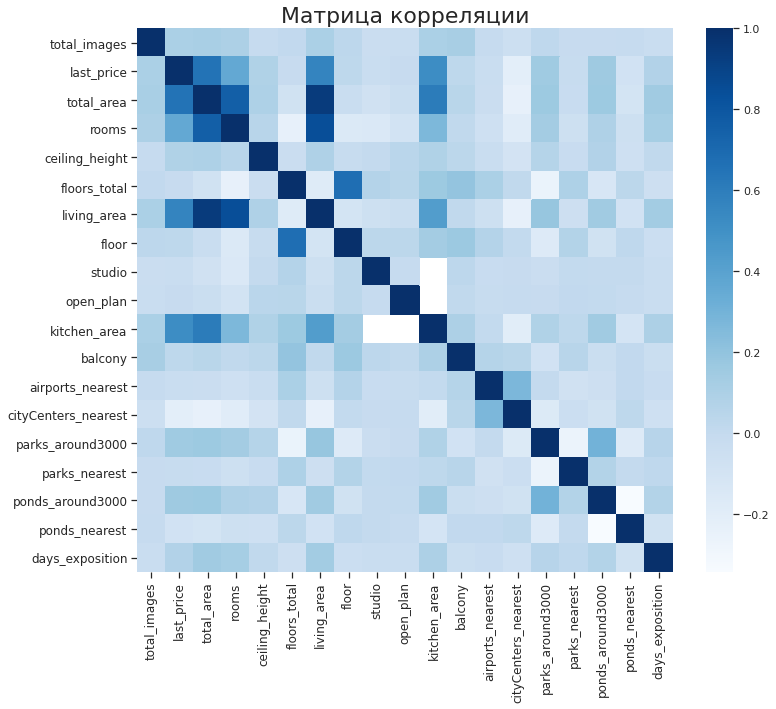

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(raw_data.corr(), xticklabels=raw_data.corr().columns, 
            yticklabels=raw_data.corr().columns, cmap='Blues')

plt.title('Матрица корреляции', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Да, в наших данных оказались очень сильные зависимости между столбцами total_area, living_area, kitchen_area, rooms и price.

Это логично, чем больше площадь квартиры, тем больше жилая площадь, скорее всего больше площадь квартиры и количество комнат. И само собой цена.

#### 1.3. Вывод по общей информации о датасете

В данном пункте проекта мы проанализировали общую информацию о предоставленном датасете. Данные дают нам довольно обширную информацию об объявлениях на площадке по продаже квартир, начиная от площади квартиры, кухни, цены, заканчивая наличием и расстоянием до парков, аэропортов и водоемов.

В результате беглого просмотра данных мы получили общие представления о датасете, выяснили, что данные довольно разнородны и среди них встречаются объявления о продажах квартир разного класса из разных населенных пунктов.

Так же мы обнаружили некоторые проблемы датасета, изучением и устранением которых займемся в следующем пункте:
1. Большое количество пропусков во множестве столбцов
2. Неявные дубликаты в столбце **locality_name**
3. Аномальные значения, которые явно выбиваются из логики (высота потолка 1 метр или 100 метров)
4. Типы данных некоторых столбцов были присвоены интерпетатором неправильно, их необходимо изменить вручную

Изучив гистограммы распределения данных, мы можем сделать вывод, что в нашем датасете больше всего квартир из пяти/девятиэтажных домов, с потолками 2,5-2,8 метра, 1/2/3 комнатами. Так же имеет место быть сильная корреляция между жилой площадью, ценой и количеством комнат.

Перейдем к предобработке данных.

### 2. Предобработка данных

В данной части проекта мы выполним предобработку данных:
1. Заполним и удалим пропуски, там где это необходимо
2. Изменим типы данных в столбцах:
* first_day_exposition - изменить тип данных на **datetime**
* floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - на **int**
* is_apartment - на **bool**
3. Проверим наличие в датасете явных дубликатов и постараемся избавиться от всех неявных дубликатов
4. Более подробно изучим аномальные значения и избавимся от них, путем замены на логичные

Откопируем нашу таблицу и далее будем работать с fixed_data.

In [19]:
fixed_data = raw_data.copy()

#### 2.1. Заполнение и удаление пропусков в таблице

Выясним, сколько пропусков содержится в таблице:

In [20]:
fixed_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Посмотрим, как пропуски распределились по датасету:

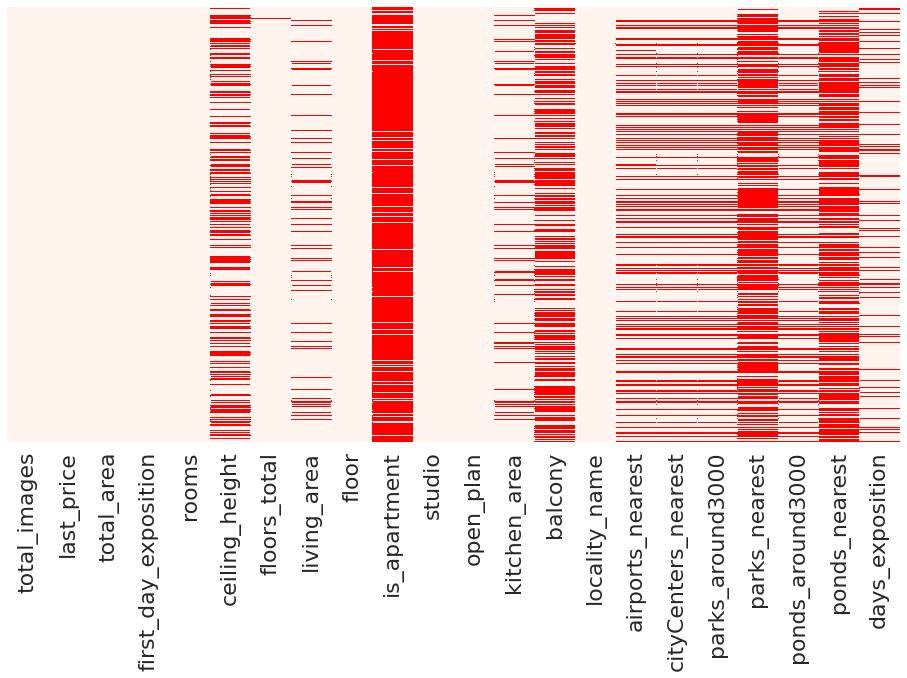

In [21]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(16,8)) 
sns.heatmap(fixed_data.isnull(), yticklabels=False, cbar=False, cmap=sns.color_palette(['seashell', 'red']),
           xticklabels=fixed_data.columns)
plt.show()
sns.set(font_scale=1)
sns.set_style('ticks', {'axes.grid': 'True'})

И каково отношение пропущенных значений ко всем значениям в датасете. Применим функцию nan_columns_list(), она описана вначале проекта, с ее помощью сразу отберем столбцы, где пропусков менее 1% датасета.

In [22]:
columns_for_drop = nan_columns_list(fixed_data, threshold=0.01)

Пропуски содержатся в 14 столбцах:
38.80% |пропусков в столбце| ceiling_height
0.36%  |пропусков в столбце| floors_total
8.03%  |пропусков в столбце| living_area
88.29% |пропусков в столбце| is_apartment
9.61%  |пропусков в столбце| kitchen_area
48.61% |пропусков в столбце| balcony
0.21%  |пропусков в столбце| locality_name
23.38% |пропусков в столбце| airports_nearest
23.29% |пропусков в столбце| cityCenters_nearest
23.28% |пропусков в столбце| parks_around3000
65.91% |пропусков в столбце| parks_nearest
23.28% |пропусков в столбце| ponds_around3000
61.56% |пропусков в столбце| ponds_nearest
13.42% |пропусков в столбце| days_exposition


Пропуски встретились нам в 14 столбцах, при этом в столбце is_apartment их вовсе 88%, расположились пропуски по данным неравномерно, некоторые строки имеют пропуски во всех этих столбцах, некоторые нет, говорить о систематической ошибке тут нельзя. Сразу начнем обработку пропусков, при этом будем указывать возможную причину их возникновения.

1. Менее 1% пропусков в столбцах floors_total и locality_name, восстановить эти данные невозможно, относительное количество пропусков мало - без зазрения совести удаляем эти строки. Пропуски в данных ячейках могли появиться по разным причинам: ошибки сохранения/загрузки, не заполненены по невнимательности и тд.

In [23]:
fixed_data = fixed_data.dropna(subset=columns_for_drop).reset_index(drop=True)

2. Пропуски в столбце **ceiling_height** заполним медианным значением в зависимости от этажности здания:

In [24]:
ceiling_height_median = fixed_data.pivot_table(index='floors_total', values='ceiling_height', aggfunc='median')
for total_floor in ceiling_height_median.index:
    fixed_data.loc[(fixed_data['ceiling_height'].isna()) & 
             (fixed_data['floors_total'] == total_floor), 'ceiling_height'] =\
                                ceiling_height_median.loc[total_floor, 'ceiling_height']
del ceiling_height_median

In [25]:
fixed_data[fixed_data['ceiling_height'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
11507,9,9900000.0,101.0,2016-04-28T00:00:00,3,NaN,33.0,53.0,32,False,False,False,21.0,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,53.0


Осталась одна строка, для нее не оказлось группы с таким количеством этажей, заполним медианным значением по всему датасету.

In [26]:
fixed_data.loc[fixed_data['ceiling_height'].isna(), 'ceiling_height'] = fixed_data['ceiling_height'].median()
fixed_data.loc[11507, 'ceiling_height']

2.65

3. Ранее мы заметили, что существует корреляция между общей площадью квартиры и жилой площадью, это позволяет нам заполнить пропуски основываясь на значениях столбца **total_area**. В нем отсутствуют пропуски.

Для начала добавим в датафрейм новый *вспомогательный* столбец **living_area_ratio**:

In [27]:
fixed_data['living_area_ratio'] = fixed_data.eval('living_area / total_area')

Изучим его отношение с общей площадью квартиры:

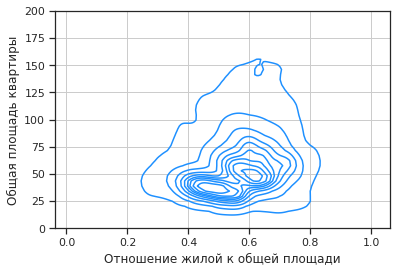

In [28]:
sns.kdeplot(x='living_area_ratio', y='total_area', data=fixed_data, color='dodgerblue')
plt.ylabel('Общая площадь квартиры')
plt.xlabel('Отношение жилой к общей площади')
plt.ylim(0,200)
plt.show()

И отношение с количеством комнат:

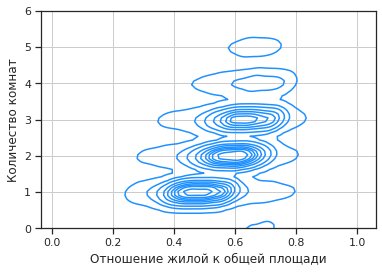

In [29]:
sns.kdeplot(x='living_area_ratio', y='rooms', data=fixed_data, color='dodgerblue')
plt.ylabel('Количество комнат')
plt.xlabel('Отношение жилой к общей площади')
plt.ylim(0,6)
plt.show()

В первом случае мы получили две моды, одну для квартир менее ~45 кв. метров, другую для квартир более 50 квадратных метров.

Во втором случае мы можем увидеть несколько ярко выраженных мод, для каждой группы. Более правильным в данном случае будет заполнить пропуски в зависимости от числа комнат, мы получим более справедливое заполнение несколькими медианами. Это является более рациональным, т.к. мы знаем, что количество комнат, площадь жилая и общая имеют положительную сильную корреляцию.

По аналогии с заполнением пропусков в **ceiling_height** создаем вспомогательную таблицу и с помощью цикла заполняем пропуски соответствующей медианой.

In [30]:
living_median = fixed_data.pivot_table(index='rooms', values='living_area_ratio', aggfunc='median')
for rooms in living_median.index:
    fixed_data.loc[(fixed_data['living_area_ratio'].isna()) & 
             (fixed_data['rooms'] == rooms), 'living_area_ratio'] =\
                                living_median.loc[rooms, 'living_area_ratio']

fixed_data.loc[fixed_data['living_area'].isna(), 'living_area'] =\
                                    fixed_data['total_area'] * fixed_data['living_area_ratio']
del living_median, fixed_data['living_area_ratio']

4. Пропуски в столбце **is_apartment** скорее всего появились по причине того, что при заполнении этой информации люди пропускали графу, если их квартира не является апартаментами. Столбец булевый, значений 1 и 0, заполняем нулями исходя из логики, что апартаментов очень маленькое количество, с большой долей вероятности жилье - обычное:

In [31]:
fixed_data['is_apartment'].fillna(0, inplace=True)

5. Займемся заполнением пропусков в столбце **kitchen_area**. Пропуски могли появиться из-за ошибок пользователя, ошибки сохранения, выгрузки и тд. Насколько мне известно, в студиях нет как таковой кухни, часть пропусков в этом столбце могла появиться из-за этого, проверим:

In [32]:
print(len(fixed_data.query('studio == 1')))
print(fixed_data.query('studio == 1')['kitchen_area'].isna().sum())

146
146


Видно, что во всех строках, содержащих информацию о квартирах студиях действительно пропущены значения, пользователи не заполнини, я поставлю 0.

In [33]:
fixed_data.loc[fixed_data['studio'] == 1, 'kitchen_area'] = 0

Для остальных строк заполним пропуски аналогично столбцу **living_area**, медианой в зависимости от количества комнат:

In [34]:
fixed_data['kitchen_area_ratio'] = fixed_data.eval('kitchen_area / total_area')
kitchen_median = fixed_data.pivot_table(index='rooms', values='kitchen_area_ratio', aggfunc='median')
for rooms in kitchen_median.index:
    fixed_data.loc[(fixed_data['kitchen_area_ratio'].isna()) & 
             (fixed_data['rooms'] == rooms), 'kitchen_area_ratio'] =\
                                kitchen_median.loc[rooms, 'kitchen_area_ratio']

fixed_data.loc[fixed_data['kitchen_area'].isna(), 'kitchen_area'] =\
                                    fixed_data['total_area'] * fixed_data['kitchen_area_ratio']
del kitchen_median, fixed_data['kitchen_area_ratio']

7. Достоверно понять, чем заполнить пропуски в **balcony**, предположим, что пропуски появились в тех строках, где пользователь не указал балкон, лишь потому что его просто нет в квартире. Исходя из этой мысли, заполним пропуски нулями.

In [35]:
fixed_data.loc[fixed_data['balcony'].isna(), 'balcony'] = 0

8. Столбец **days_exposition**, пропуски в нем могли появиться из-за неправильной выгрузки базы данных.

Мы не можем заполнить эти пропуски медианным значением, это сильно исказит дальнейшую работу с этим столбцом. Вот так выглядит гистограмма без заполнения:

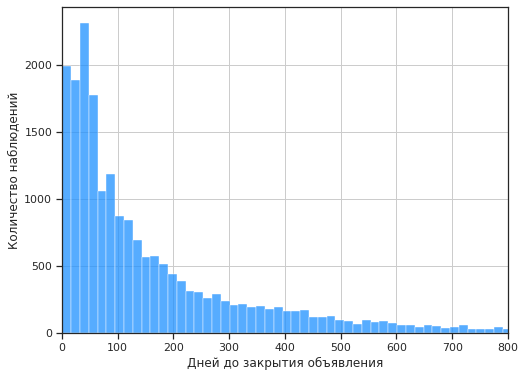

In [36]:
plt.figure(figsize=(8,6))
sns.histplot(fixed_data['days_exposition'], bins=100, color='dodgerblue')
plt.xlabel('Дней до закрытия объявления')
plt.ylabel('Количество наблюдений')
plt.xlim(0,800)
plt.show()

При заполнении мы получим моду именно на медиане:

In [37]:
new_days = fixed_data['days_exposition'].fillna(fixed_data['days_exposition'].median())

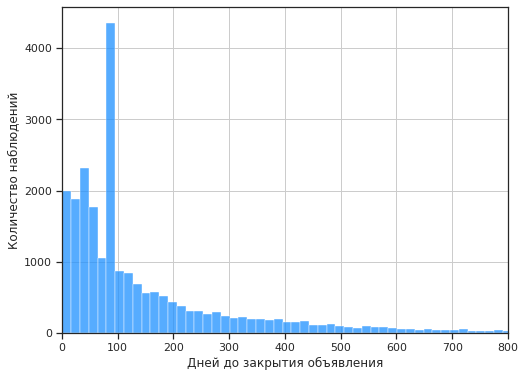

In [38]:
plt.figure(figsize=(8,6))
sns.histplot(new_days, bins=100, color='dodgerblue')
plt.xlabel('Дней до закрытия объявления')
plt.ylabel('Количество наблюдений')
plt.xlim(0,800)
plt.show()

In [39]:
del new_days

Другая причина, по которой пропуски могли появиться в датафрейме - объявления на момент выгрузки данных были активными и продажа не произошла. Изучим внимательнее:

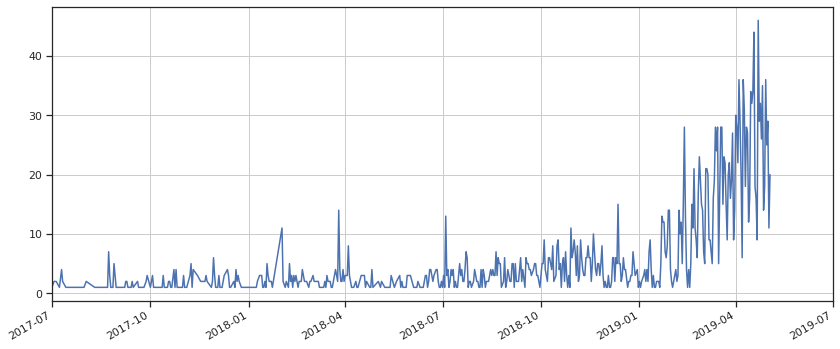

In [40]:
import datetime
nans_days_exposition = fixed_data[fixed_data['days_exposition'].isna()].reset_index(drop=True)
nans_days_exposition['first_day_exposition'] = pd.to_datetime(nans_days_exposition['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
ser = pd.Series(nans_days_exposition.groupby('first_day_exposition')['first_day_exposition'].count())
date = ser.index

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(date, ser)
fig.autofmt_xdate()
ax.set_xlim([datetime.date(2017, 7, 1), datetime.date(2019, 7, 1)])
plt.show()

Большая часть объявлений пришлась на 2019 год, с большой долей вероятностью пропуски в этом столбце из-за того, что квартиры к моменту выгрузки датасета не были проданы. **Не будем удалять эти строки и оставим без обработки.**

9. Пропуски в столбцах с картографическими данными: **airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest**. Данные в этих столбцах заполнялись благодаря автоматической системе (скорее всего от адреса). По этой же причине, скорее всего, появились пропуски в строках. Для некоторых городов и населенных пунктов эта система просто не работает.

В этих столбцах скопилось очень большое количество пропусков, от 20 до 60%. Мы никак не можем восстановить эти данные.

Удалить эти данные мы не можем, не можем так же и заполнить их медианными значениями/средними и тд, т.к. при заполнении такого большого количества пропусков, мы просто-напросто исказим наши гистограммы большим количеством медианных значений.

В таком случае мы можем либо оставить пропуски без обработки, либо промаркировать их каким-либо значением, например -1 и не отрисовывать его на диаграммах, задав координаты. Оба подхода приводят к одному и тому же, оставим без обработки.

Проверим, заполнили ли мы пропуски согласно нашей логики, и все прошло корректно:

In [41]:
fixed_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

С пропусками покончено, переходим к изменению типов данных.

#### 2.2. Изменение типов данных

Во время изучения общей информации о датасете мы обнаружили, что для некоторых столбцов интерпритатор pandas присвоил не совсем верные типы данных:
* first_day_exposition - изменить тип данных на **datetime**
* floors_total, balcony, parks_around3000, ponds_around3000, days_exposition - на **int**
* is_apartment - на **bool**

Исправим это в данном пункте проекта.

1. Столбец **first_day_exposition** должен иметь тип данных datetime

In [42]:
fixed_data['first_day_exposition'] = pd.to_datetime(fixed_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

2. Некоторым столбцам с числовыми данными более подошел бы тип целочисленных значений, **int**, т.к. информация содержащаяся в них скорее целочисленная.

Столбцам parks_around3000, ponds_around3000 мы не можем задать тип **int**, т.к. в них содержатся NaN (float).

In [43]:
cols_float_type = ['floors_total', 'balcony', 'days_exposition', 'parks_around3000', 'ponds_around3000']
for col in cols_float_type:
    fixed_data[col] = np.floor(pd.to_numeric(fixed_data[col], errors='coerce')).astype('Int64')

In [44]:
fixed_data['last_price'] = fixed_data['last_price'].astype(int)

3. Столбец **is_apartment** является числовым и содержит значения 0 и 1, по сути он является булевым False и True. Изменим его тип.

In [45]:
fixed_data['is_apartment'] = fixed_data['is_apartment'].astype(bool)

Проверим наш датафрейм, все ли изменения в нем произошли корректно:

In [46]:
fixed_data[['first_day_exposition', 'last_price', *cols_float_type, 'is_apartment']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   first_day_exposition  23565 non-null  datetime64[ns]
 1   last_price            23565 non-null  int64         
 2   floors_total          23565 non-null  Int64         
 3   balcony               23565 non-null  Int64         
 4   days_exposition       20394 non-null  Int64         
 5   parks_around3000      18065 non-null  Int64         
 6   ponds_around3000      18065 non-null  Int64         
 7   is_apartment          23565 non-null  bool          
dtypes: Int64(5), bool(1), datetime64[ns](1), int64(1)
memory usage: 1.4 MB


Все ок, движемся дальше, проверим таблицу на дубликаты и избавимся от них при наличии.

#### 2.3. Обработка дубликатов

Необходимо избавиться от неявных дубликатов, единственным столбцов в данном датасете, который может содержать неявные дубликаты является столбец **locality_name**, еще раз посмотрим, какие уникальные значения он содержит:

In [47]:
fixed_data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Сколько всего уникальных значений?

In [48]:
len(fixed_data['locality_name'].unique())

364

Для начала проверим, есть ли в датасете буквы "ё", заменим их на "е"

In [49]:
print('Букв ё:',fixed_data['locality_name'].str.count('ё').sum())

Букв ё: 2166


In [50]:
fixed_data['locality_name'] = fixed_data['locality_name'].str.replace('ё', 'е')

При изучении списка уникальных значений, мы обнаружили, что все названия населенных пунктов или имеют первую часть, состоящую из нижнего регистра, и вторую часть, состоящую из наименования, либо просто наименование. Разобьем строки с помощью функции **splitter**, которую мы написали.

In [51]:
splitter.__doc__

'Функция разбивает переданную в нее строчку на две подстроки\n       При этом одна из подстрок будет только нижнего регистра, другая только верхнего\n       Возвращает строку нижнего и верхнего регистра в виде кортежа'

Применим нашу функцию и создадим вспомогательный датафрейм.

In [52]:
splitted_locality = fixed_data['locality_name'].apply(splitter).apply(pd.Series)
splitted_locality.columns = ['Приставка', 'Наименование']
splitted_locality.head()

,Приставка,Наименование
0,,Санкт-Петербург
1,поселок,Шушары
2,,Санкт-Петербург
3,,Санкт-Петербург
4,,Санкт-Петербург


Проверим, что функция отработала по всему датафрейму:

In [53]:
len(fixed_data) == len(splitted_locality)

True

Отыщем дубликаты:
1. Шаг 1, сгруппируем вспомогательный датафрейм по наименованию и приставке, добавим столбец из единиц
2. Шаг 2, группируем датафрейм из первого шага по наименованию, считаем сумму
3. Шаг 3, отбираем только те наименования, где сумма оказалась больше 1
4. Шаг 4, выбираем из датафрейма 1 только те наименования, где сумма оказалась больше 1

In [54]:
step1 = splitted_locality.groupby(['Наименование', 'Приставка']).first()
step1['Подсчет'] = 1
step2 = step1.groupby('Наименование').sum()
step3 = step2.query('Подсчет > 1')
del step1['Подсчет']
step4 = step1.query('Наименование in @step3.index')

In [55]:
step4

Empty DataFrame
Columns: []
Index: [(Большая Ижора, городской поселок), (Большая Ижора, поселок городского типа), (Вещево, поселок при железнодорожной станции), (Вещево, поселок станции), (Гарболово, деревня), (Гарболово, поселок), (Громово, поселок), (Громово, поселок станции), (Зимитицы, деревня), (Зимитицы, поселок), (Калитино, деревня), (Калитино, поселок), (Кудрово, ), (Кудрово, деревня), (Лесное, коттеджный поселок), (Лесное, поселок), (Лесогорский, городской поселок), (Лесогорский, поселок городского типа), (Любань, ), (Любань, поселок), (Мга, городской поселок), (Мга, поселок городского типа), (Мурино, ), (Мурино, поселок), (Назия, городской поселок), (Назия, поселок городского типа), (Никольское, ), (Никольское, село), (Павлово, городской поселок), (Павлово, поселок городского типа), (Павлово, село), (Приветнинское, поселок при железнодорожной станции), (Приветнинское, поселок станции), (Приладожский, поселок городского типа), (Приладожский, садовое товарищество), (Рабитицы, деревня), (Рабитицы, поселок), (Рахья, поселок городского типа), (Рахья, садовое товарищество), (Рощино, городской поселок), (Рощино, поселок городского типа), (Рябово, поселок), (Рябово, поселок городского типа), (Советский, городской поселок), (Советский, поселок городского типа), (Федоровское, городской поселок), (Федоровское, деревня), (Щеглово, деревня), (Щеглово, поселок)]

Осталось разобраться, где в данном случае дубликаты, а где - нет. Потратим немного (upd. много) времени и погуглим.
1. городской поселок Большая Ижора и поселок городского типа Большая ижора - **дубликаты**.
2. поселок при железнодорожной станции Вещево и поселок станции Вещево - **дубликаты**.
3. деревня Гарболово и поселок Гарболово - **дубликаты**.
4. поселок Громово и поселок при станции Громово - не дубликаты.
5. деревня Зимитицы и поселок Зимитицы - не дубликаты.
6. деревня Калитино и поселок Калитино - не дубликаты.
7. Кудрово (город) и деревня Кудрово - не дубликаты.
8. коттеджный поселок Лесное и поселок Лесное - не дубликаты.
9. поселок городского типа Лесогорский и городской поселок Лесогорский - **дубликаты**.
10. Любань (город) и (Любань поселок и Любань городской поселок)
Дубликаты тут поселок Любань и городской поселок Любань, правильное название будет поселок городского типа Любань.
11. городской поселок Мга и поселок городского типа Мга - **дубликаты**.
12. Мурино (город) и поселок Мурино - **дубликаты**, поселок Мурино был переименован в город.
13. поселок городского типа Назия и городской поселок Назия - **дубликаты**.
14. село Никольское и город Никольское - **дубликаты**, с 1990 года это город.
15. село Павлово и (городской поселок и поселок городского типа Павлово)
Дубликаты тут городской поселок и поселок городского типа Павлово, заменим на поселок городского типа Павлово.
16. поселок при железнодорожной станции Приветнинское и поселок станции Приветнинское - **дубликаты**.
17. поселок городского типа Приладожский и садовое товарищество Приладожский - **дубликаты**. Правильно: поселок городского типа
18. деревня Рабитцы и поселок Рабитцы - **дубликаты**, правильное название - деревня Рабитцы.
19. поселок городского типа Рахья и садовое товарищество Рахья - **дубликаты**, правильное назавние: поселок городского типа Рахья
20. поселок городского типа и городской поселок Рощино - **дубликаты**.
21. поселок городского типа Рябово и поселок Рябово - не дубликаты.
22. городской поселок Федоровское и деревня Федоровское - **дубликаты**. Правильно: поселок городского типа
23. деревня Щеглово и поселок Щеглово - **дубликаты**. Правильное название поселок Щеглово.

Обработаем дубликаты:

Для некоторых можно обойтись заменой "городской поселок" на "поселок городского типа" или на "поселок при ж/д станции", для других придется действовать более точечно.

In [56]:
fixed_data['locality_name'] = fixed_data['locality_name'].str.replace('городской поселок', 'поселок городского типа')
fixed_data['locality_name'] = fixed_data['locality_name'].str.replace('поселок станции', 'поселок при железнодорожной станции')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('деревня Гарболово', 'поселок Гарболово')
fixed_data['locality_name'] = fixed_data['locality_name'].replace(['поселок Любань', 'городской поселок Любань'], 'поселок городского типа Любань')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('поселок Мурино', 'Мурино')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('село Никольское', 'Никольское')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('садовое товарищество Приладожский', 'поселок городского типа Приладожский')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('поселок Рабитцы', 'деревня Рабитцы')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('садовое товарищество Рахья', 'поселок городского типа Рахья')
fixed_data['locality_name'] = fixed_data['locality_name'].replace(['городской поселок Федоровское', 'деревня Федоровское'], 'поселок городского типа Федоровское')
fixed_data['locality_name'] = fixed_data['locality_name'].replace('деревня Щеглово', 'поселок Щеглово')

In [57]:
del splitted_locality, step1, step2, step3, step4

In [58]:
len(fixed_data['locality_name'].unique())

314

Неявные дубликаты устранены, количество уникальных значений сократилось.

#### 2.3. Обработка редких и выбивающихся значений

##### 2.3.1. Изучение общей информации

В данной части проекта постараемся отыскать аномальные значения в столбцах и устранить их по возможности.

Устранять аномалии в столбцах с картографическими данными не будем, нет совершенно никакого понимания, какие значения там должны быть.

In [59]:
columns_to_correct = ['last_price', 'total_area', 'rooms', 'ceiling_height',
 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony']

Выведем основные статистические показали этих столбцов:

In [60]:
fixed_data[columns_to_correct].describe()

,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony
count,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000
mean,6.540058e+06,60.322824,2.070656,2.735737,10.675875,34.690633,5.878124,10.393608,0.593677
std,1.091093e+07,35.657060,1.078591,0.996999,6.594823,22.854323,4.871485,5.860345,0.960660
min,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
25%,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.700000,2.000000,7.000000,0.000000
50%,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000
75%,6.790000e+06,69.700000,3.000000,2.750000,16.000000,42.332797,8.000000,11.755467,1.000000
max,7.630000e+08,900.000000,19.000000,100.000000,60.000000,430.133948,33.000000,122.359566,5.000000


Сразу бросаются в глаза следующие аномальные значения:
1. **last_price** - максимум 763 млн. руб., минимум 12 тыс. руб.
В случае максимума, жилье премиум класса с большой площадью и расположением в центре города вполне стоит таких денег в наше время.
В случае минимума, скорее всего при вводе была допущена ошибка и реальная цена может быть 1.2 млн, 12 млн., 120 млн. руб.
2. **total_area** - максимум 900 кв. м., минимум 12 кв. м. Оба варианта вполне реальны, жилье премиум класса (например целый этаж в высотке на Котельнической набережной в Москве) и 12 кв. метров. - самые маленькие квартиры студии, однако может быть и ошибка при заполнении.
3. **rooms** - максимум 19, минимум 0. Нужно подробнее изучить квартиры с 0 комнатами.
4. **ceiling_height** - высота потолка максимум 100 метров, минимум 1 метр. Тут явно ошибки сверху и снизу.
5. **floors_total** - сверху и снизу вполне корректные значения.
6. **living_area** - максимум 430 и минимум 2. Подробнее изучим эти строки
7. **floor** - все ок
8. **kitchen_area** - минимум 0, квартиры студии, максимум 122, ошибка при вводе?
9. **balcony** - 5 балконов, конечно, такая квартира может существовать, но она очень далека от обычной квартиры и является выбросом.

Построим боксплоты для столбцов, для наглядности будем строить по 3 за раз. Вычислим так же положения "усов" боксплота, сколько значений попало внутрь межквартильного размаха, сколько осталось снаружи. Все это сделаем с помощью написанной нами функции draw_three_boxplots().

Начнем с площади:

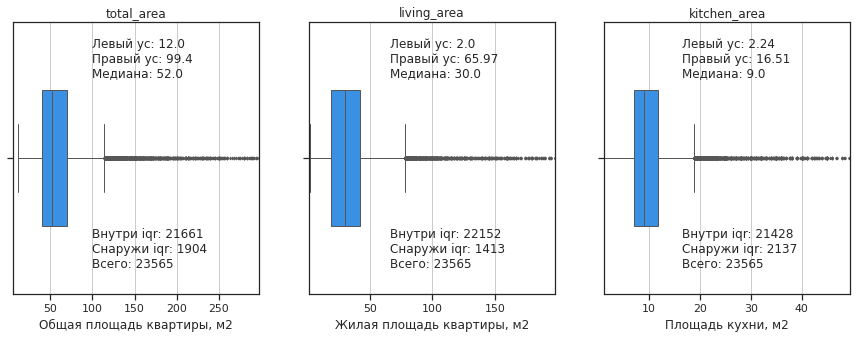

In [61]:
columns_to_draw = ['total_area', 'living_area', 'kitchen_area']
draw_three_boxplots(fixed_data, columns_to_draw)

Большая часть значений оказалась внутри межквартильного размаха, что с точки зрения описательной статистики хорошо.

Стоит ли обрезать данные по границам размаха? Нет, не стоит, в таком случае мы потеряем большое количество данных, причем только с одного конца, по сути удалим весь правый конец. Данные можно нормализовать, например прологарифмировав их, тогда мы получим нормальное распределение, вычислим стандартное отклонение и отсечем только данные, которые находтся за 3 стандартными отклонениями.

Далее рассмотрим столбцы цены, количества комнат и высоты потолка:

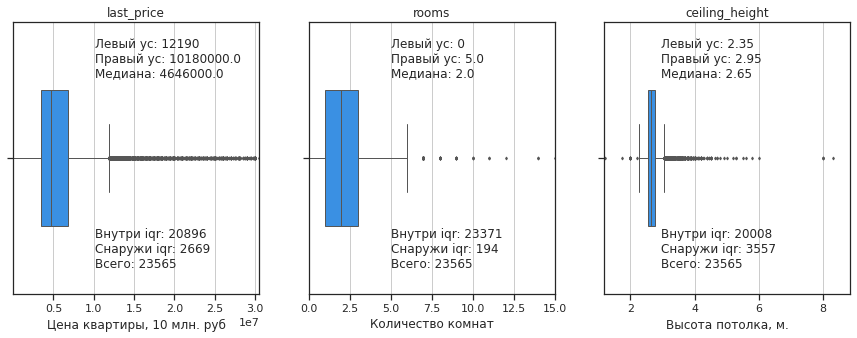

In [62]:
columns_to_draw = ['last_price', 'rooms', 'ceiling_height']
draw_three_boxplots(fixed_data, columns_to_draw)

Распределение цены и количества комнат, в целом - ок, имеет положительный скос, не очень большое количество выбросов.

Хуже дела обстоят с колонкой высоты потолка, оказывается, много значений лежит ниже 2 метров, и выше 5 метров, что маловероятно, изучим этот столбец более подробно позже.

Остались столбцы этажа, количества этажей в доме и количества балконов, построим их боксплоты:

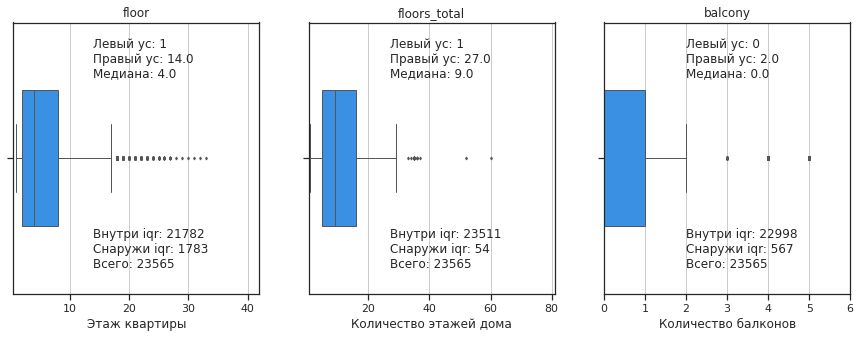

In [63]:
columns_to_draw = ['floor', 'floors_total', 'balcony']
draw_three_boxplots(fixed_data, columns_to_draw)

Ранее во время изучения общей информации мы выяснили, что в нашем датафрейме нет значений **floor** которые были бы больше чем **floors_total**. Оба этих столбца вполне могут иметь значения от 1 до 60, как представлено в датафрейме, их обработка не требуется.

Количество балконов в квартире: почти все данные оказались оказались внутри размаха, данные сильно скошено, это логично. Скорее всего 3, 4, 5 балконов имеют квартиры, с большой площадью, например, которые могли быть образованы в результате соединения нескольких квартир.

##### 2.3.2. Обработка аномальных значений

1. Сначала посмотрим, какие квартиры имеют цену меньше 400 тыс.

In [64]:
fixed_data.query('last_price < 0.4e6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8750,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8


Одна квартира, из Санкт-Петербурга, с двумя комнатами и большой площадью, посмотрим, какая медиана у похожих квартир:

In [65]:
condition = 'locality_name == "Санкт-Петербург" and ' +\
'rooms == 2 and ' +\
'(total_area > 80) and ' +\
'(total_area < 140)' +\
'and last_price != 12190.0'

In [66]:
fixed_data.query(condition)['last_price'].median()

12490375.0

Все таки пользователь ошибся при вводе цены, реальная цена примерно 12 млн.

In [67]:
fixed_data.loc[8750, 'last_price'] = 12190000

2. Посмотрим, какие строки имеют потолки больше 40 метров:

In [68]:
fixed_data.query('ceiling_height > 40')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22739,0,15000000,25.0,2018-07-25,1,100.0,5,14.0,5,True,False,False,11.0,5,Санкт-Петербург,34963.0,8283.0,1,223.0,3,30.0,19


Одна строка, удалим ее.

In [69]:
fixed_data = fixed_data.drop(22739).reset_index(drop=True)

Какие строки имеют потолки выше 20 метров:

In [70]:
fixed_data.query('ceiling_height > 20')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
353,17,3600000,55.2,2018-07-12,2,25.0,5,32.0,2,False,False,False,8.889066,2,Гатчина,NaN,NaN,<NA>,NaN,<NA>,NaN,259
3134,14,2900000,75.0,2018-11-12,3,32.0,3,53.0,2,False,False,False,8.000000,0,Волхов,NaN,NaN,<NA>,NaN,<NA>,NaN,<NA>
4621,0,4300000,45.0,2018-02-01,2,25.0,9,30.0,2,False,False,False,7.000000,1,Санкт-Петербург,12016.0,13256.0,1,658.0,1,331.0,181
4852,7,3000000,25.0,2017-09-27,0,27.0,25,17.0,17,False,False,True,0.000000,2,Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,28
5051,0,3850000,30.5,2018-10-03,1,24.0,5,19.5,1,True,False,False,5.500000,0,Санкт-Петербург,29686.0,8389.0,3,397.0,1,578.0,7
5219,0,2500000,54.0,2017-10-13,2,27.0,5,30.0,3,False,False,False,9.000000,2,деревня Мины,NaN,NaN,<NA>,NaN,<NA>,NaN,540
5641,4,4400000,50.0,2017-08-08,2,26.0,9,21.3,3,False,False,False,7.000000,2,Санкт-Петербург,28981.0,10912.0,1,305.0,0,NaN,267
5777,17,8150000,80.0,2019-01-09,2,27.0,36,41.0,13,False,False,False,12.000000,5,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,38
6213,6,3300000,44.4,2019-03-25,2,25.0,5,31.3,5,False,False,False,5.700000,0,Кронштадт,68923.0,50649.0,1,417.0,2,73.0,<NA>
9334,5,3950000,42.0,2017-03-26,3,25.0,5,30.0,2,False,False,False,5.200000,0,Санкт-Петербург,11647.0,13581.0,0,NaN,0,NaN,<NA>


Тут заметна систематическая ошибка, пользователи забыли поставить запятую или поставили не там, поправим их:

In [71]:
condition = fixed_data['ceiling_height'] > 20
fixed_data.loc[condition, 'ceiling_height'] = fixed_data.loc[condition, 'ceiling_height'] / 10

In [72]:
fixed_data.loc[22211,'ceiling_height']

3.2

Изменение сработало, так будет корректнее.

Какие строки имеют потолки выше 5 метров:

In [73]:
fixed_data.query('ceiling_height > 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
395,15,5990000,54.0,2018-03-22,2,14.85,36,21.400000,28,False,False,False,18.700000,1,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,11
461,15,66571000,280.3,2015-06-11,6,5.20,8,159.500000,7,False,False,False,21.100000,0,Санкт-Петербург,26316.0,6655.0,3,187.0,1,616.0,578
1022,20,155000000,310.0,2018-10-12,5,5.30,3,190.000000,3,False,False,False,63.000000,2,Санкт-Петербург,24899.0,4785.0,0,NaN,1,603.0,<NA>
1383,20,59800000,399.0,2015-01-21,5,5.60,6,260.085109,6,False,False,False,42.049180,0,Санкт-Петербург,26204.0,6934.0,2,149.0,2,577.0,719
3459,3,1400000,30.0,2018-03-16,1,8.00,5,15.300000,2,False,False,False,7.300000,0,деревня Нурма,NaN,NaN,<NA>,NaN,<NA>,NaN,125
5833,20,5650000,45.0,2018-08-15,1,8.30,16,19.300000,14,False,False,False,8.300000,1,Санкт-Петербург,13069.0,10763.0,0,NaN,1,613.0,14
7540,17,38000000,143.0,2017-11-02,3,5.50,5,83.000000,5,False,False,False,29.000000,1,Санкт-Петербург,26333.0,6448.0,3,479.0,0,NaN,<NA>
12557,14,3900000,50.0,2018-03-29,1,5.30,5,24.131884,5,False,False,False,12.382065,0,Санкт-Петербург,19644.0,3918.0,1,505.0,1,92.0,8
14975,19,5600000,56.4,2018-05-11,2,14.00,14,32.400000,5,False,False,False,9.100000,2,Санкт-Петербург,14814.0,13610.0,0,NaN,0,NaN,315
15656,14,5600000,67.0,2016-11-11,3,8.00,16,41.000000,1,False,False,False,8.000000,0,Санкт-Петербург,32691.0,11035.0,1,723.0,0,NaN,474


Тут нет какой-либо логики, почему потолки такие, по мне это выбивающиеся значения, удалим их.

In [74]:
fixed_data = fixed_data.drop(fixed_data[fixed_data['ceiling_height'] > 5].index).reset_index(drop=True)

Проверим:

In [75]:
fixed_data.query('ceiling_height > 5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Потолки меньше 2 метров, какие там значения?

In [76]:
fixed_data.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5678,5,1500000,42.8,2017-08-14,2,1.20,2,27.5,1,False,False,False,5.20,0,поселок городского типа Мга,NaN,NaN,<NA>,NaN,<NA>,NaN,248
16827,5,4100000,40.0,2017-10-17,1,1.75,37,17.4,5,False,False,False,8.34,0,Санкт-Петербург,18732.0,20444.0,0,NaN,3,80.0,71
22448,16,6000000,55.0,2018-10-31,2,1.00,12,32.4,7,False,False,False,10.00,0,Санкт-Петербург,33053.0,14217.0,2,293.0,2,289.0,13


Тоже удалим их:

In [77]:
fixed_data = fixed_data.drop(fixed_data.query('ceiling_height < 2').index).reset_index(drop=True)
len(fixed_data.query('ceiling_height < 2'))

0

3. Количество комнат более 10, посмотрим какие там строки:

In [78]:
fixed_data.query('rooms > 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
643,3,17500000,183.7,2018-07-01,11,3.40,7,138.8,7,False,False,False,13.3,0,Санкт-Петербург,23606.0,3148.0,0,NaN,0,NaN,<NA>
860,5,25000000,363.0,2017-12-23,14,3.16,5,222.0,4,False,False,False,16.6,0,Санкт-Петербург,38076.0,7950.0,0,NaN,2,435.0,418
5325,20,65000000,590.0,2019-02-14,15,3.50,6,409.0,3,False,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1,767.0,0,NaN,14
9634,8,33000000,194.1,2017-02-07,11,3.43,5,129.0,2,False,False,False,11.9,0,Санкт-Петербург,21469.0,1015.0,1,686.0,2,66.0,813
14405,6,32250000,374.6,2018-06-09,19,2.55,5,264.5,2,False,False,False,27.6,0,Санкт-Петербург,19497.0,3574.0,0,NaN,2,548.0,114
18730,6,28500000,270.0,2015-03-02,16,3.00,4,180.0,4,False,False,False,13.0,1,Санкт-Петербург,23575.0,4142.0,1,516.0,0,NaN,1365
19417,8,420000000,900.0,2017-12-06,12,2.80,25,409.7,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106
20697,6,28659000,245.4,2016-03-31,14,3.00,4,168.3,2,False,False,False,25.9,0,Санкт-Петербург,21104.0,2054.0,3,541.0,2,118.0,95


Впринципе, тут большие квартиры, с большой и очень большой площадью, не будем их править или удалять.

Посмотрим на строки, которые имеют 0 комнат, может быть у всех них "открытый план"?

In [79]:
fixed_data.query('rooms == 0 and studio == False')['open_plan'].value_counts()

True    59
Name: open_plan, dtype: int64

Так и есть, править не будем.

4. Количество балконов в квартире обрабатывать не будем, достоверно понять, какое там значение реально, невозможно. Можно удалить эти строки, с другой стороны это могут быть вполне реальные значения.

5. Изучим квартиры меньше 15 кв. метров и более 600 кв. метров:

In [80]:
fixed_data.query('total_area < 15')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17845,3,1400000,13.0,2017-12-03,1,2.60,9,6.274290,1,False,False,False,3.219337,0,Санкт-Петербург,14350.0,15945.0,0,NaN,1,185.0,410
19423,3,1850000,13.0,2019-03-11,1,3.40,5,6.274290,2,False,False,False,3.219337,0,Санкт-Петербург,24915.0,5483.0,1,644.0,0,NaN,24
19435,2,1686000,13.2,2018-12-17,1,2.55,5,6.370817,1,False,False,False,3.268865,0,Санкт-Петербург,19891.0,4165.0,1,361.0,1,155.0,19
19519,5,1190000,14.0,2018-07-29,1,2.55,5,11.000000,1,False,False,False,2.000000,0,Санкт-Петербург,9898.0,11122.0,0,NaN,0,NaN,4
19684,0,3800000,13.0,2018-07-04,1,2.55,5,10.000000,3,False,False,False,3.219337,0,Санкт-Петербург,21302.0,1242.0,1,592.0,3,27.0,9
19781,4,2400000,12.0,2017-07-19,1,2.55,5,10.000000,2,False,False,False,2.971696,0,Санкт-Петербург,21314.0,964.0,1,886.0,2,45.0,200


In [81]:
fixed_data.query('total_area > 600')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3099,19,140000000,631.0,2019-03-30,7,2.55,5,430.133948,5,False,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,<NA>
12778,20,140000000,631.2,2019-04-09,7,3.90,4,322.300000,4,False,False,False,19.5,1,Санкт-Петербург,25707.0,4972.0,0,NaN,2,210.0,<NA>
15555,20,300000000,618.0,2017-12-18,7,3.40,7,258.000000,5,False,False,False,70.0,0,Санкт-Петербург,32440.0,5297.0,0,NaN,2,198.0,111
19417,8,420000000,900.0,2017-12-06,12,2.80,25,409.700000,25,False,False,False,112.0,0,Санкт-Петербург,30706.0,7877.0,0,NaN,2,318.0,106


В целом это вполне реальные квартиры, что большие, что маленькие, странностей тут я не вижу.

6. Проверим столбец площади кухни, но выведем те квартиры, где отношение кухни к общей площади больше 0.6

In [82]:
fixed_data.query('kitchen_area/total_area > 0.5')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
506,7,5950000,69.00,2017-12-21,1,2.70,16,13.000000,12,False,False,False,50.00,1,Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,56
674,14,7200000,43.00,2017-10-31,1,2.80,8,9.000000,2,False,False,False,23.00,0,Санкт-Петербург,23900.0,5232.0,1,2137.0,1,933.0,296
690,1,3364930,34.69,2014-11-27,1,2.64,25,23.430000,25,False,False,False,23.43,2,Санкт-Петербург,43396.0,12153.0,0,NaN,0,NaN,574
1318,8,8100000,52.00,2017-01-29,2,2.70,25,9.000000,15,False,False,False,32.00,2,Санкт-Петербург,35555.0,15561.0,0,NaN,1,1180.0,337
1328,12,18500000,66.00,2017-06-08,1,3.00,7,25.000000,7,False,False,False,35.00,1,Санкт-Петербург,NaN,NaN,<NA>,NaN,<NA>,NaN,130
1398,9,3250000,24.60,2018-06-29,1,2.75,25,18.000000,16,False,False,False,18.20,0,Санкт-Петербург,35250.0,16414.0,0,NaN,1,400.0,96
2297,10,4200000,62.40,2017-06-15,2,2.60,9,8.400000,6,False,False,False,41.00,2,поселок Шушары,23662.0,29448.0,0,NaN,0,NaN,111
2430,18,15000000,72.00,2016-04-25,2,3.66,5,21.300000,5,False,False,False,37.80,0,Санкт-Петербург,22990.0,2445.0,2,508.0,1,267.0,85
3272,13,3400000,42.30,2017-01-24,1,2.70,20,11.900000,3,False,False,False,21.90,0,Мурино,NaN,NaN,<NA>,NaN,<NA>,NaN,14
3541,5,12300000,115.00,2017-08-09,3,2.70,20,45.000000,16,False,False,False,60.00,1,Санкт-Петербург,33386.0,14234.0,0,NaN,0,NaN,63


Выглядит так, как будто пользователи ошиблись, когда вводили площади и перепутали площадь кухни и жилую площадь местами.

Или это действительно такие большие кухни, ответить на этот вопрос мы не можем, оставим без обработки.

7. Столбец **living_area** точно по той же логике пропускаем без обработки.

8. И внимательно изучим столбец **days_exposition**:

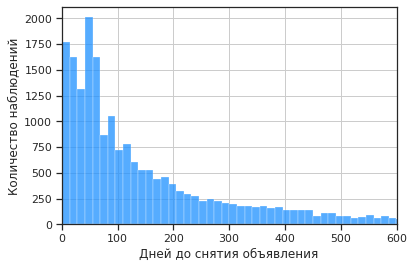

In [83]:
sns.histplot(fixed_data['days_exposition'], color='dodgerblue')
plt.xlabel(cols_descr_dict.get('days_exposition'))
plt.ylabel('Количество наблюдений')
plt.xlim(0,600)
plt.show()

Логично предположить, что тут мы должны увидеть примерно гамма распределение, с постепенным уменьшением количества наблюдений, при увеличении количества дней объявления. Однако вырисовываются две моды на отрезке от 0 до 70, укрупним:

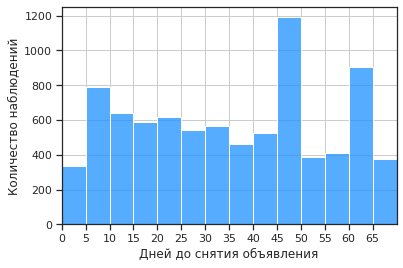

In [84]:
sns.histplot(fixed_data['days_exposition'], color='dodgerblue', bins=[x for x in range(0,80,5)])
plt.ylabel('Количество наблюдений')
plt.xlabel(cols_descr_dict.get('days_exposition'))
plt.xlim(0,70)
plt.xticks([x for x in range(0,70,5)])
plt.show()

Заметно, что где-то на 45 и на 60 днях значительно больше объявлений снимается с сайта:

In [85]:
print('День 44, объявлений снято:', len(fixed_data.query('days_exposition == 44')))
print('День 45, объявлений снято:', len(fixed_data.query('days_exposition == 45')))
print('День 46, объявлений снято:', len(fixed_data.query('days_exposition == 46')))

День 44, объявлений снято: 138
День 45, объявлений снято: 879
День 46, объявлений снято: 90


In [86]:
print('День 59, объявлений снято:', len(fixed_data.query('days_exposition == 59')))
print('День 60, объявлений снято:', len(fixed_data.query('days_exposition == 60')))
print('День 61, объявлений снято:', len(fixed_data.query('days_exposition == 61')))

День 59, объявлений снято: 106
День 60, объявлений снято: 538
День 61, объявлений снято: 108


Мы предполагаем, что все таки в этот день происходило автоматическое снятие объявлений, квартиры на самом деле не были проданы, а пользователи могли создать новое объявление/уйти на другую площадку и тд. В таком случае, удалим эти строки.

In [87]:
fixed_data = fixed_data.drop(fixed_data[fixed_data['days_exposition'] == 45].index).reset_index(drop=True)
fixed_data = fixed_data.drop(fixed_data[fixed_data['days_exposition'] == 60].index).reset_index(drop=True)

#### 2.3.3. Обработка экстремальных значений

Так же необходимо провести обработку от редких, выбивающихся значений.

Побороться с такими значениями можно в столбцах общей площади и цены. В них отсутствуют нулевые значения, а значит можно просто прологарифмировать их.

In [88]:
log_data = fixed_data[['last_price', 'total_area']].apply(np.log2)
log_data.head()

,last_price,total_area
0,23.632008,6.754888
1,21.675730,5.336283
2,22.308970,5.807355
3,25.951715,7.312883
4,23.253497,6.643856


Проверяем, что наши данные прологарифмировались и нормализовались:

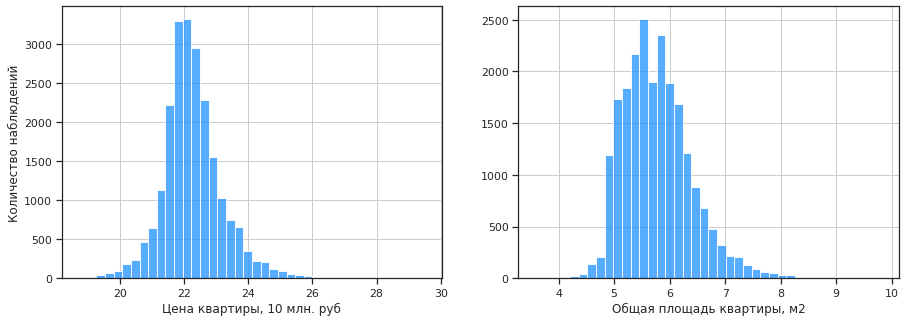

In [89]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
for i, feature in enumerate(log_data.columns):
    plt.subplot(1,2,i+1)
    sns.histplot(log_data[feature], bins = 40, color = 'dodgerblue', kde=False)
    plt.xlabel(cols_descr_dict.get(feature))
    if i in (0,3):
        plt.ylabel('Количество наблюдений')
    else:
        plt.ylabel('')

Удалим из датасета значения, которые находятся за пределами 3 стандартных отклонения и отсечем по индексам в исходном датасете удаленные данные. В таком случае мы избавимся от 1% экстремальных значений. С очень большой долей вероятности выбросы уйдут и из других столбцов: количества комнат, жилой площади, площади кухни, ведь как мы помним, эти столбцы имеют очень сильную корреляцию.

In [90]:
log_data = log_data.loc[(log_data['last_price'] > min_max_by_std(log_data, 'last_price')[0]) &
                        (log_data['last_price'] < min_max_by_std(log_data, 'last_price')[1]) &
                        (log_data['total_area'] > min_max_by_std(log_data, 'total_area')[0]) &
                        (log_data['total_area'] < min_max_by_std(log_data, 'total_area')[1])]

fixed_data = fixed_data.query('@fixed_data.index in @log_data.index').reset_index(drop=True)
del log_data

На этом предобработку данных можно считать законченной:

In [91]:
percent = 1 - (len(fixed_data)/len(raw_data))
print(f'Мы удалили в результате предобработки {percent:.2%} данных.')

Мы удалили в результате предобработки 8.42% данных.


#### 2.4. Вывод по предобработке данных

На первом этапе предобработки данных мы обрабатывали пропущенные значения в 14 столбцах датасета, заполняя их медианными значениями по группам, удаляя или исправляя.
1. Пропуски в столбцах **floors_total** и **locality_name** мы удалили, т.к. их количество было невелико (менее 1%).
2. Пропуски в столбце **ceiling_height** заполнили медианным значением в зависимости от этажности здания.
3. Пропуски в столбцах **living_area** и **kitchen_area** мы заполнили медианой в зависимости от количества комнат в квартире.
4. Пропуски в столбце **is_apartment** мы заполнили нулями исходя из логики, что данные ячейки были не заполнены умышленно.
5. Пропуски в столбце **balcony** заполнили нулями, исходя из той логики, что пользователи не заполнили графу, если у них нет балкона.
6. Пропуски в столбце **days_exposition** мы оставили без обработки, т.к. с большой долей вероятности пропуски в этом столбце возникли лишь по той причине, что квартира еще не была продана.
7. Пропуски в столбцах с картографическими данными мы оставили без обработки, т.к. нет возможности правильно восстановить данные, какие должны быть в этих столбцах.

На втором этапе предобработки мы изменили типы данных столбцов:
* first_day_exposition - с **object** на **datetime**
* floors_total, balcony, days_exposition - с **float** на **int**
* is_apartment - **object** на **bool**

На третьем этапе предобработки данных мы искали повторяющиеся значения в названиях населенных пунктов, нам удалось найти дубликаты, в основном связанные с разным написанием уточнения к населенному пункту, например: городской поселок и поселок городского типа.

На четвертом этапе предобработки мы искали аномальные значения, отлавливали ошибки, которые можно исправить и избавлялись от редких и выбивающихся значений. Нам удалось найти несколько ошибок в высоте потолка, почистить эти значения и исправить, исправить маленькую цену на жилье, а так же отсечь выбивающиеся значения. Так же мы обнаружили большое количество объявлений, которые были сняты на 45 и 60 день, мы удалили эти значения, т.к. посчитали, что они были сняты автоматически.

В результате предобработки данных мы избавились от 8.42%, причем самое большое удаление данных пришлось на удаление аномальных значений в столбце **days_exposition**.

### 3. Добавление в таблицу новых признаков

Посчитаем и добавим в таблицу следующие данные:
1. Цену за квадратный метр
2. День недели объявления
3. День месяца объявления
4. Год объявления
5. Категорию этажа: первый, последний, другой
6. Расстояние до центра в км.

Добавим эти признаки:

In [92]:
fixed_data['price_per_meter'] = fixed_data['last_price'] / fixed_data['total_area']
fixed_data['weekday'] = fixed_data['first_day_exposition'].dt.weekday
fixed_data['month'] = fixed_data['first_day_exposition'].dt.month
fixed_data['year'] = fixed_data['first_day_exposition'].dt.year

fixed_data.loc[fixed_data['floor'] == 1, 'floor_category'] = 'первый'
fixed_data.loc[fixed_data['floor'] == fixed_data['floors_total'], 'floor_category'] = 'последний'
fixed_data.loc[(fixed_data['floor'] != 1) & (fixed_data['floor'] !=\
                                             fixed_data['floors_total']), 'floor_category'] = 'другой'
fixed_data['cityCenters_nearest_km'] = round(fixed_data['cityCenters_nearest']/1000)

Для столбца с днем недели заменим значения на понятные:

In [93]:
weekday_dict = {0:'Понедельник',
                1:'Вторник',
                2:'Среда',
                3:'Четверг',
                4:'Пятница',
                5:'Суббота',
                6:'Воскресенье'}

In [94]:
fixed_data['weekday'] = fixed_data['weekday'].map(weekday_dict)

### 4. Исследовательский анализ данных

На данном этапе проекта с помощью графиков более подробно исследуем подготовленные данные.

Проанализируем, как зависит цена квартиры от разных параметров, найдем 10 самых дорогих по стоимости жилья населенных пунктов в окресностях Санкт-Петербурга, а так же более подробно изучим квартиры в самом Санкт-Петербурге.

In [95]:
final_data = fixed_data.copy()
del fixed_data

#### 4.1. Исследование общих параметров квартиры

Для каждого из общих параметров квартиры построим гистограммы, вычислим характерные статистические значения и проанализируем.

##### 4.1.1. Общая площадь квартиры

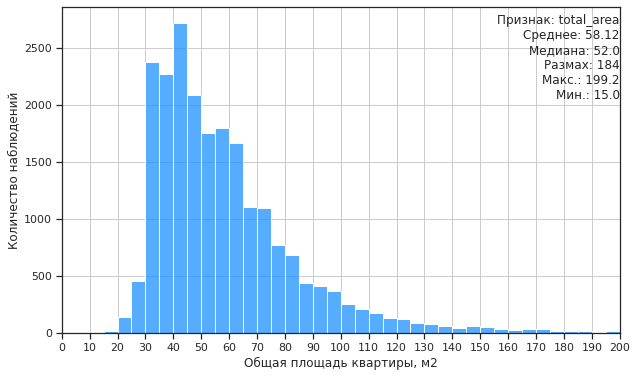

In [96]:
draw_hist(df=final_data, col='total_area', bins=np.arange(0,201,5), xlim=(0,200), xticks=np.arange(0,201,10))

Первый параметр - **общая площадь квартиры**, распределение напоминает гамма распределение, с длинным правым хвостом.

Самая часто встречающаяся квартира имеет площадь 40-45 кв. метров, средняя квартира по датасету имеет площадь 50 кв. метров, самая большая 199 кв. метров, а самая маленькая 15 кв. метров (после отсечения выбивающихся значений). Среднее значение смещено относительно моды из за наличия длинного правого хвоста.

##### 4.1.2. Жилая площадь квартиры

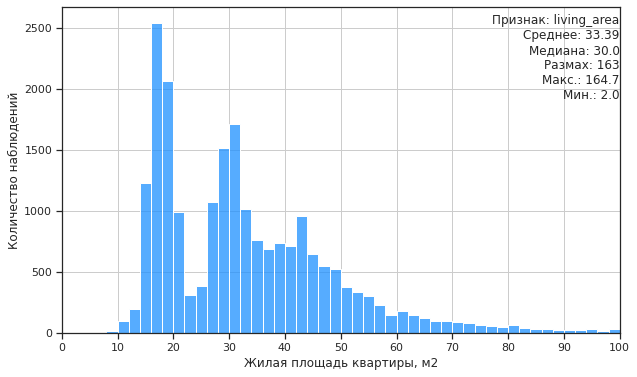

In [97]:
draw_hist(df=final_data, col='living_area', bins=np.arange(0,101,2), xlim=(0,100), xticks=np.arange(0,101,10))

Следующий параметр - **жилая площадь квартиры**, имеет два пика, первый на 14-18 кв. метрах, следующий на 26-32 кв. метрах. Распределение практически бимодальное, с длинным правым хвостом. Средняя квартира в датасете имеет 30 кв. метров жилой площади, максимальная 164 кв. метра.

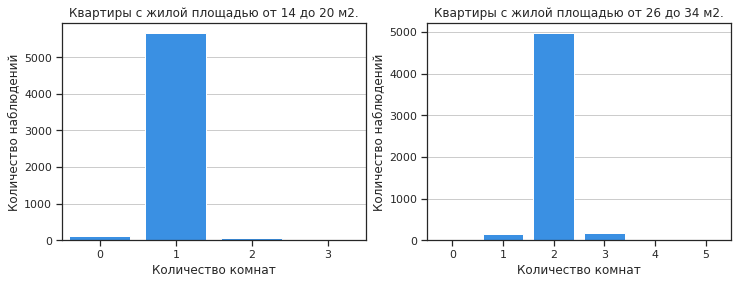

In [98]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='rooms', data=final_data.query('20 > living_area >= 14'), color='dodgerblue')
plt.ylabel('Количество наблюдений')
plt.xlabel(cols_descr_dict['rooms'])
plt.title('Квартиры с жилой площадью от 14 до 20 м2.')

plt.subplot(1,2,2)
sns.countplot(x='rooms', data=final_data.query('34 > living_area >= 26'), color='dodgerblue')
plt.ylabel('Количество наблюдений')
plt.xlabel(cols_descr_dict['rooms'])
plt.title('Квартиры с жилой площадью от 26 до 34 м2.')
plt.show()

В левом пике расположились только однокомнатные квартиры и квартиры студии, в правом в основном двухкомнатные квартиры.

##### 4.1.3. Площадь кухни

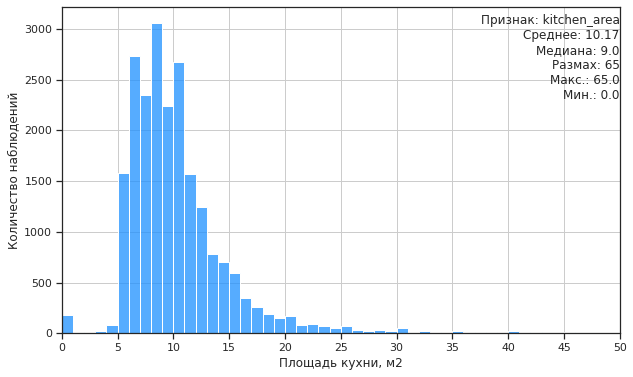

In [99]:
draw_hist(df=final_data, col='kitchen_area', bins=np.arange(0,51,1), xlim=(0,50), xticks=np.arange(0,51,5))

Распределение параметра **площадь кухни** так же напоминает гамма распределение, при этом заметен маленький пик от 0 до 2 кв. метров, в основном это квартиры-студии, как мы выяснили ранее. Средняя кухня имеет площадь от 8 до 9 квадратных метров, это практически стандартная кухня самого обычного дома.

##### 4.1.4. Стоимость квартиры

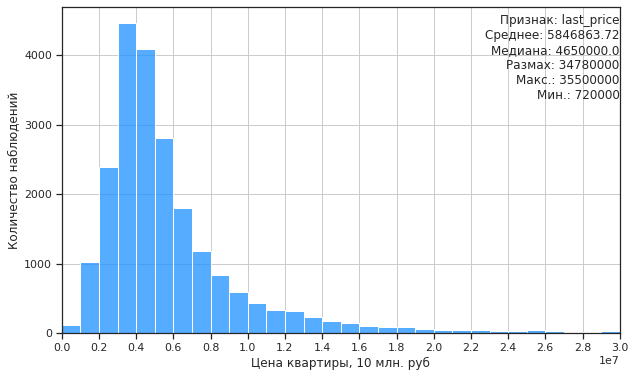

In [100]:
draw_hist(final_data, 'last_price', np.arange(0,3.1e7,1e6), (0,3e7), xticks = np.arange(0,3.1e7,2e6))

Чаще всего в датасете представлены квартиры стоимостью от 3 до 4 млн рублей, большая часть квартир имеет стоимость от 2 до 6 млн. рублей, есть и более дорогие квартиры, вплоть до 32 млн. руб., самая дешевая квартира стоит 720 тыс. руб. Учитывая, что датасет содержит объявления с 2014 до 2019 года, это вполне реальные значения.

Более подробно цену квартиры, а так же ее зависимость от различных параметров, мы будем изучать далее, в отдельной части проекта.

##### Количество комнат

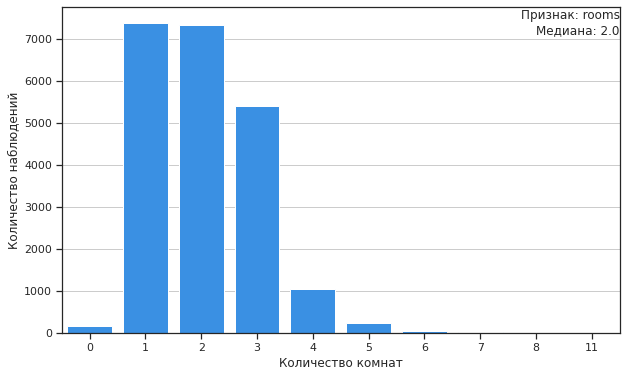

In [101]:
draw_count(df=final_data, col='rooms')

**Количество комнат**, Практически одинаковое количество однокомнатных и двукомнатных квартир представлено в датасете, следом идут трехкомнатные квартиры. В датасете после предобработки остались и 11-комнатные квартиры, однако мы помним, что изначально была представлена даже 19-комнатная квартира.

Как мы помним, была сильная зависимость между количеством комнат и общей площадью квартиры, визуализируем ее:

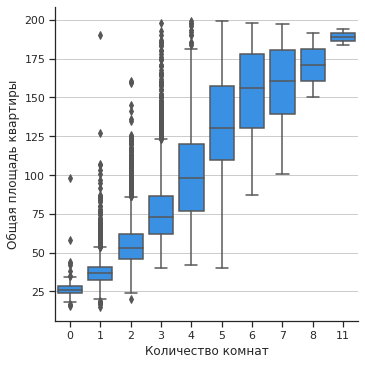

In [102]:
sns.catplot(x='rooms', y='total_area', kind="box", data=final_data, showfliers = True, color='dodgerblue')
plt.xlabel('Количество комнат')
plt.ylabel('Общая площадь квартиры')
plt.show()

Действительно, зависимость практически линейная, за редкими исключениями, присутствуют в датасете так же и однокомнатные квартиры с большой площадью, возможно это аномальные значения.

##### 4.1.5. Высота потолка

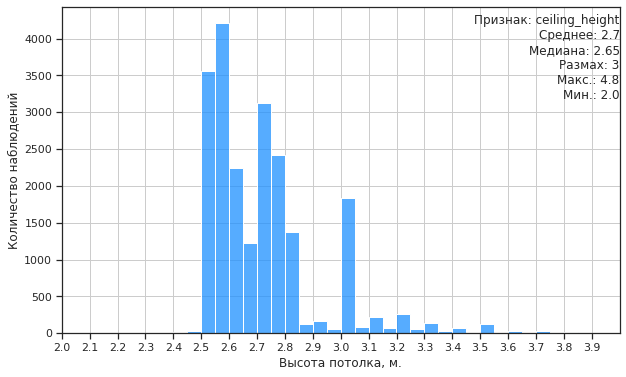

In [103]:
draw_hist(df=final_data, col='ceiling_height', bins=np.arange(2,4,0.05), xlim=(2,4), xticks=np.arange(2,4,0.1))

**Высота потолка** - каждый застройщик выбирает свою высоту потолка, впринципе большое количество стандартных значений прослеживается на гистограмме, это 2.5 - 2.65 метра, 2.7, 2.8, 3 метра, вполне реальные квартиры.

Как известно, в центре Санкт-Петербурга нет хрущевок и высокие потолки, проверим это:

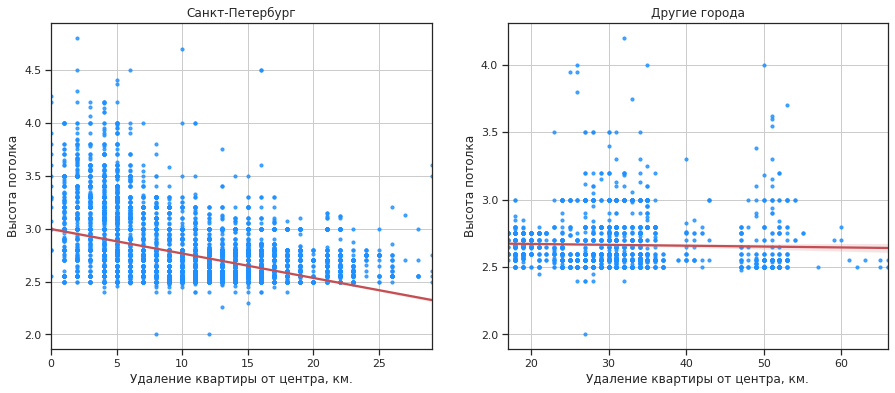

In [104]:
spb = final_data.query('locality_name == "Санкт-Петербург"')
not_spb = final_data.query('locality_name != "Санкт-Петербург"')

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='cityCenters_nearest_km', y='ceiling_height', data=spb, 
            color='dodgerblue', scatter_kws={'s': 10}, line_kws={'color':'r'})
plt.title('Санкт-Петербург')
plt.ylabel('Высота потолка')
plt.xlabel('Удаление квартиры от центра, км.')

plt.subplot(1,2,2)
sns.regplot(x='cityCenters_nearest_km', y='ceiling_height', data=not_spb, 
            color='dodgerblue', scatter_kws={'s': 10}, line_kws={'color':'r'})
plt.title('Другие города')
plt.ylabel('Высота потолка')
plt.xlabel('Удаление квартиры от центра, км.')

plt.show()

Действительно, чем ближе мы к центру Санкт-Петербурга, тем больше разброс данных, причем квартир с потолками больше 2.5 метров много. В других городах такой зависимости не прослеживается, большая часть застройки маленьких городов это новостройки или панельные дома.

##### 4.1.6. Этаж квартиры

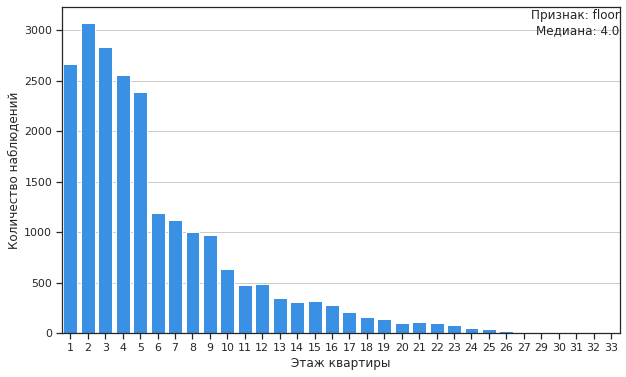

In [105]:
draw_count(df=final_data, col='floor')

Большая часть квартир расположилась на низких этажах, от 1 до 5 этажа, это объясняется большим количеством пятиэтажных домов в датасете (и в России). Далее данные стремительно убывают, что тоже вполне логично, чем больше этажей в доме, тем меньше таких домов.

##### 4.1.7. Тип этажа квартиры

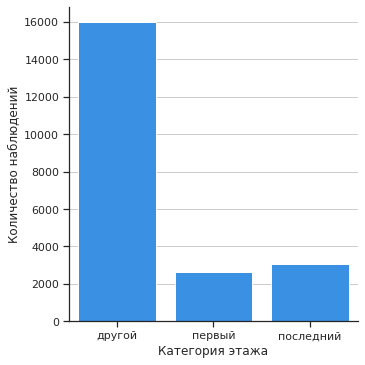

In [106]:
sns.catplot(x='floor_category', data=final_data, kind='count', color='dodgerblue')
plt.ylabel('Количество наблюдений')
plt.xlabel('Категория этажа')
plt.show()

Так же большая часть квартир расположилась между первым и последним этажом, это тоже вполне логично. Количество квартир на первом и последнем этаже дома отличается не очень сильно, это тоже логично, если выразиться очень грубо, то вероятности того, что квартира на первом или последнем этаже равны между собой.

##### 4.1.8. Общее количество этажей в доме

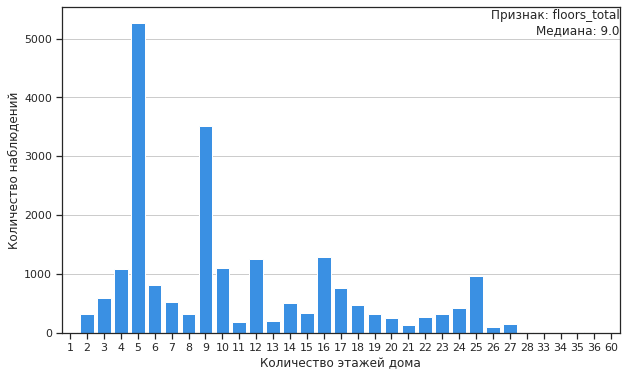

In [107]:
draw_count(df=final_data, col='floors_total')

Отчетливо видно, что больше всего в датасете пятиэтажных домов, девятиэтажных домов и 12-этажек. Домов с другой этажностью значительно меньше.

##### 4.1.9. Расстояние до центра города

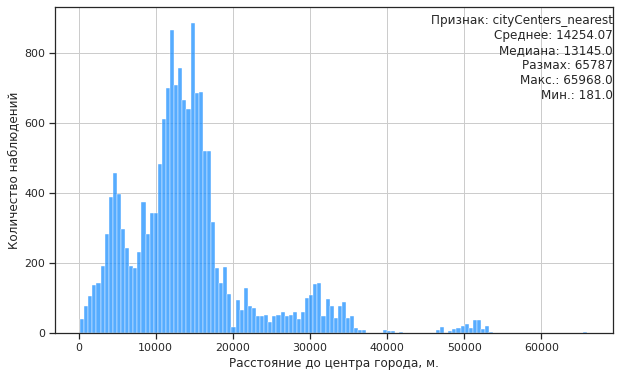

In [108]:
draw_hist(df=final_data, col='cityCenters_nearest')

Большая часть квартир расположилась в 20 км. от центра города, есть так же и квартиры в 60 км. от центра города. Посмотрим на графики по Санкт-Петербургу и другим городам:

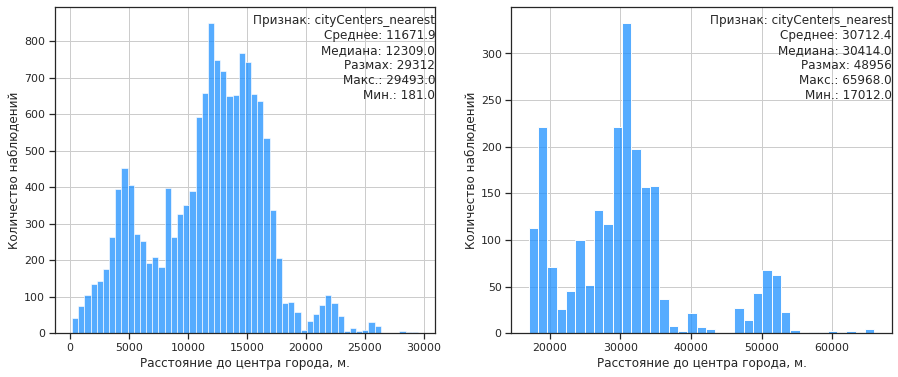

In [109]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (15,6))

plt.subplot(1,2,1)
draw_hist(df=final_data.query('locality_name == "Санкт-Петербург"'), col='cityCenters_nearest', figsize=None)

plt.subplot(1,2,2)
draw_hist(df=final_data.query('locality_name != "Санкт-Петербург"'), col='cityCenters_nearest', figsize=None)

Слева Санкт-Петербург, справа - другие города.

Получилось довольно интересно, в Санкт-Петербурге большая часть квартир расположилась на расстоянии от 10 до 20 км, скорее всего в этих районах большие спальные районы.

По другим городам: близко к центру нет ни одной квартиры, скорее всего большая часть других городов - пригороды Санкт-Петербурга, для другой части картографические данные скорее всего просто отсутствуют.

##### 4.1.10. Расстояние до аэропорта

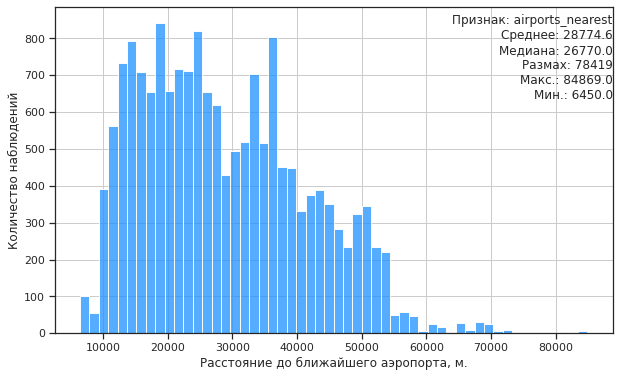

In [110]:
draw_hist(df=final_data, col='airports_nearest')

Квартиры расположились как довольно близко к аэропортам, так и очень далеко (минимум 6450 метров, максимум почти 85 км.).

##### 4.1.11. Расстояние до парка

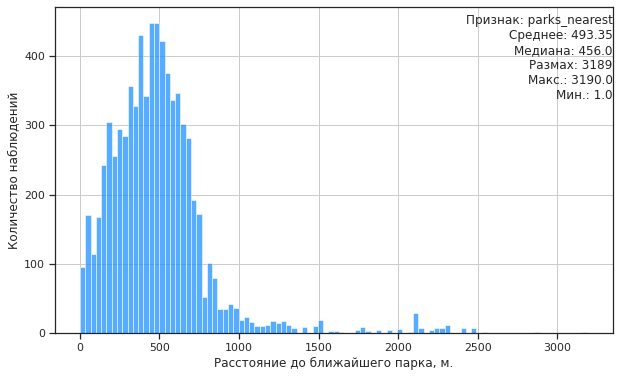

In [111]:
draw_hist(df=final_data, col='parks_nearest')

Большая часть квартир недалеко от парка, максимум в километре, но есть квартиры и очень удаленные (до 3 км.).

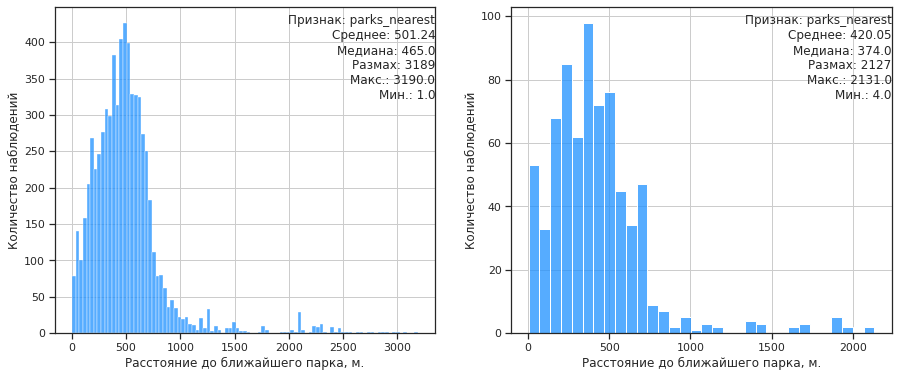

In [112]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (15,6))

plt.subplot(1,2,1)
draw_hist(df=final_data.query('locality_name == "Санкт-Петербург"'), col='parks_nearest', figsize=None)

plt.subplot(1,2,2)
draw_hist(df=final_data.query('locality_name != "Санкт-Петербург"'), col='parks_nearest', figsize=None)

Слева - Санкт-петербург, справа - другие города.

Впринципе разительных отличий между Санкт-Петербургом и другими городами нет.

##### 4.1.12. Дата публикации объявления

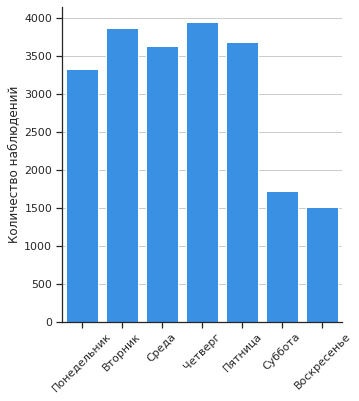

In [113]:
sns.catplot(x='weekday', data=final_data, kind='count', color='dodgerblue', order=[x for x in weekday_dict.values()])
plt.xlabel('')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=45)
plt.show()

По дням недели, заметно что в будни дни плюс-минус одинаковое количество публикаций, а вот на выходных люди отдыхают и не размещают объявления, или в эти дни не работают риелторы.

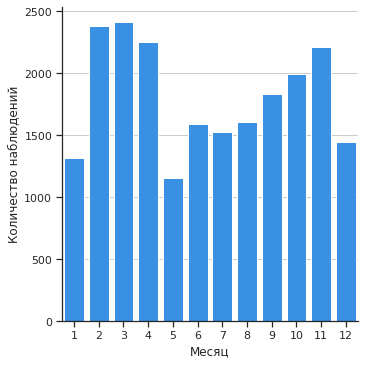

In [114]:
sns.catplot(x='month', data=final_data, kind='count', color='dodgerblue', order=np.arange(1,13,1))
plt.xlabel('Месяц')
plt.ylabel('Количество наблюдений')
plt.show()

По месяцам заметно, что в Январе, Мае и Декабре намного меньше публикацией, чем в другие месяцы, возможно причина этому праздники.

И по всему датасету:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


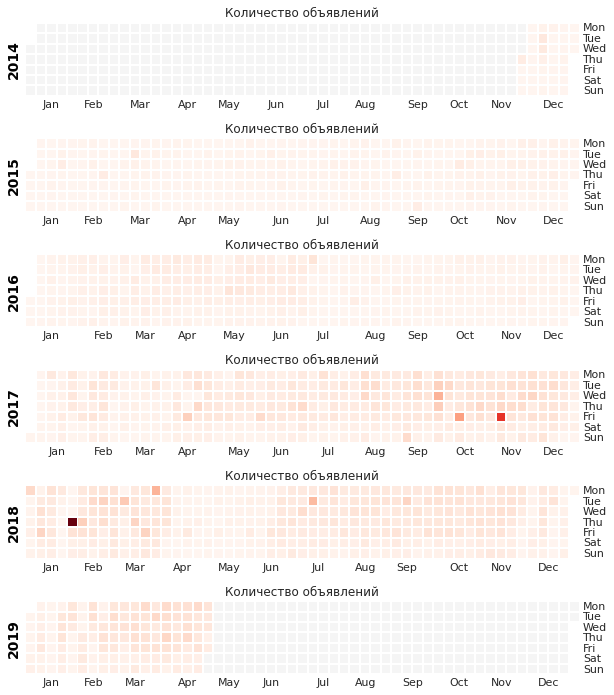

In [115]:
calmap.calendarplot(pd.Series(final_data.groupby('first_day_exposition')['first_day_exposition'].count()), 
                    fig_kws={'figsize': (16,10)},
                   yearlabel_kws={'color':'black', 'fontsize':14},
                   subplot_kws={'title':'Количество объявлений'})
plt.show()

В датасете данные с 2014 года по 2019 год. В декабре 2014 года Яндекс.Недвижимость начала принимать пользовательские объявления, нам предоставлен датасет с самого начала работы площадки для обычных пользователей. Конец апреля 2019 года - момент выгрузки датасета. Как можно заметить постепенно площадка набирала популярность, пик которой пришелся на 2017-2018 год.

Так же на датасете виднеются несколько более насыщенных дней в 2017 и 2018 годах. В них опубликовали очень большое количество объявлений, это могло произойти по разным причинам, сработала реклама, добавили какую то новую фичу/акцию для пользователей и тд.

#### 4.2. Изучение скорости продажи квартиры

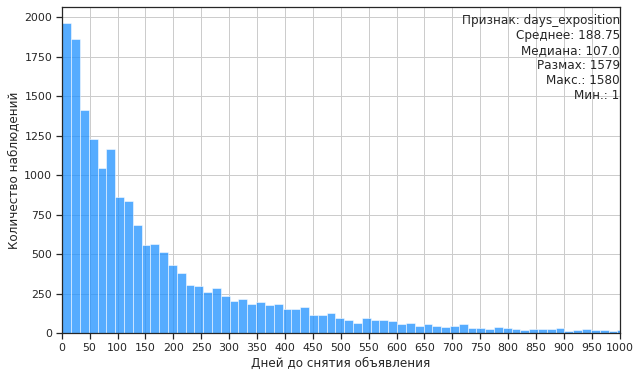

In [116]:
draw_hist(df=final_data, col='days_exposition', bins=100, xlim=(0,1000), xticks=np.arange(0,1001,50))

Ранее мы удалили из столбца данные по снятым объявлениям в 45 и 60 день (исходя из предположения, что в эти дни происходило автоматическое снятие объявлений).

* Новая медиана: 107 дней
* Новое среднее: 188 дней

Судя по датасету в среднем продажа квартиры занимает 107 дней.

Далее чисто мои мысли:

По большому счету данный признак не является характеристикой скорости продажи квартиры, а скорее является скоростью снятия объявления с площадки.

В случае, если бы этот признак являлся скоростью продажи квартиры, мы бы с большой долей вероятности увидели бы тут логнормальное распределение.

Однако мы видим один из частных случаев гамма распределения (альфа=1). Это можно объяснить тем, что люди зачастую могли снимать объявления сами, например в один из первых дней, их могла автоматически снимать система модерации объявлений, объявления могли быть мошенническими, объявления могли быть на других площадках, на которых и происходила продажа. Этим объяняется наличие большого количества объявлений снятых в первые дни публикации.

В нормальном случае, я бы ожидал, что график распределения частот будет быстро нарастать, достигая максимума примерно на 6-9 неделях, затем очень медленно уменьшаться, и мы бы получили логнормальное распределение. В таком случае мы бы смогли точно вычислить стандартное отклонение, задать доверительный интервал (например задав доверительный интервал равным по 2 сигма с двух сторон, мы бы оставили 95% данных и отсекли по 2,5% слишком быстрых или долгих продаж) и отсечь концы, которые бы посчитали слишком быстрыми и слишком медленными продажами.

Но в данном случае мы можем только предположить, какие продажи можно посчитать быстрыми. Действительно, в ленивом режиме, с плохими фото, неадекватной ценой, квартира может висеть на площадке годами, например пока рост цен на квартиры не догонит стоимость в объявлении. Быстрее чем за месяц продать квартиру редко кому удается, учитывая, что квартиру нужно показывать, согласовывать время показа. Даже первый показ может растянуть на неделю или две.

Будем считать, что: 
* **слишком быстрые продажи происходили быстрее чем за 5 недель (35 дней)**
* **слишком долгие продажи происходили дольше чем за 2 года (730 дней)**

In [117]:
len(final_data.query('days_exposition > 35 and days_exposition < 730'))/len(final_data)

0.6346588029304704

В таком случае мы отбросим 26% данных как слишком быстрые или медленные продажи.

#### 4.3. Исследование зависимости цены от различных параметров квартиры: площади, количества комнат, этажа и даты размещения объявления

Построим графики зависимости цены от общей площади квартиры, жилой площади и площади кухни:

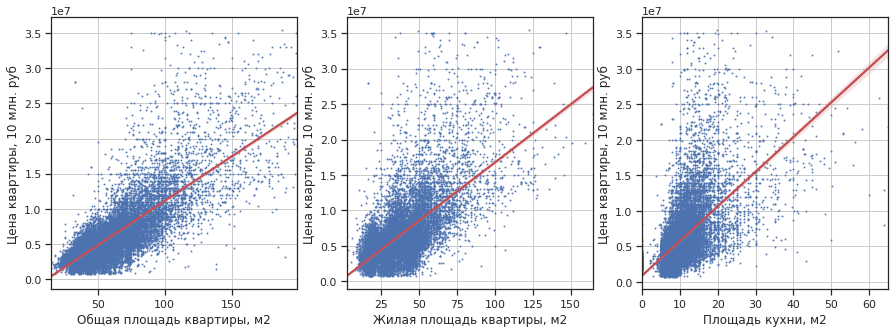

In [118]:
fix, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
features = ['total_area', 'living_area', 'kitchen_area']
for i, feature in enumerate(features):
    plt.subplot(1,3,i+1)
    sns.regplot(x=feature, y='last_price', data=final_data, scatter_kws={'s': 1}, line_kws={'color':'r'})
    plt.xlabel(cols_descr_dict.get(feature))
    plt.ylabel(cols_descr_dict.get('last_price'))

Действительно, ранее замеченная корреляция сохраняется и после очистки данных.

Чем больше площадь квартиры, жилая площадь или площадь кухни, тем выше цена на квартиру. Так же категоризируем эти параметры и построим боксплоты для каждой категории:

In [119]:
final_data['total_area_cut'] = pd.cut(final_data['total_area'], bins=np.arange(0,201,25))
final_data['living_area_cut'] = pd.cut(final_data['living_area'], bins=np.arange(0,176,25))
final_data['kitchen_area_cut'] = pd.cut(final_data['kitchen_area'], bins=np.arange(0,71,10))

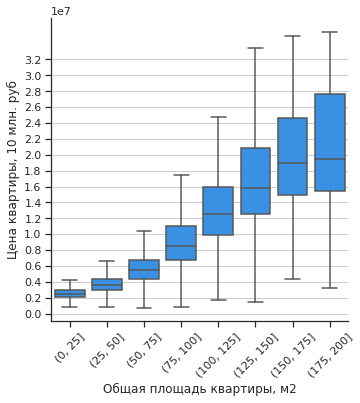

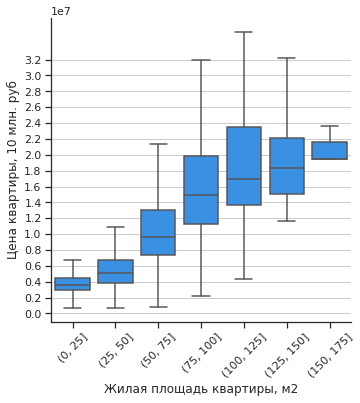

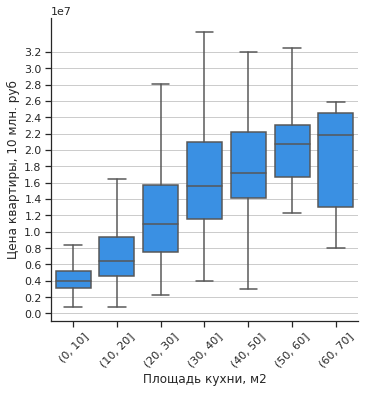

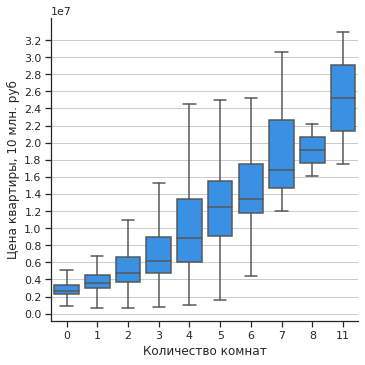

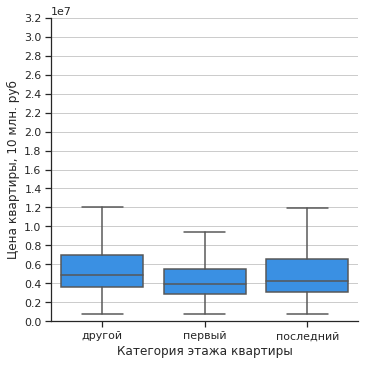

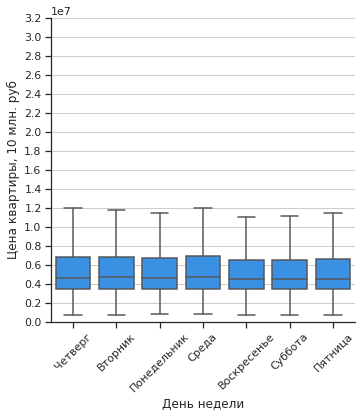

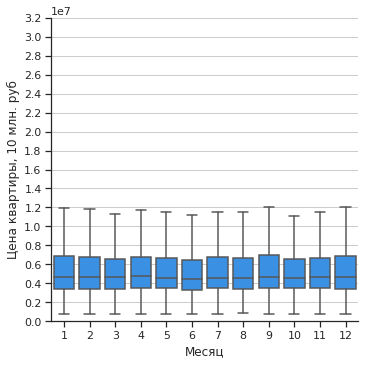

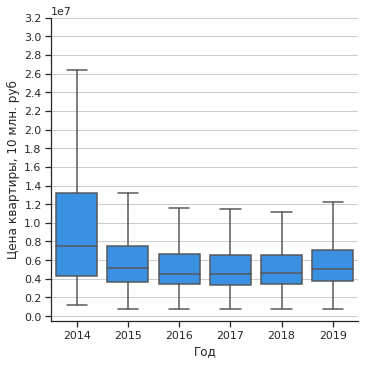

In [120]:
features = ['total_area_cut', 'living_area_cut', 'kitchen_area_cut', 'rooms', 
            'floor_category', 'weekday', 'month', 'year']


for i, feature in enumerate(features):
    sns.catplot(x=feature, y='last_price', kind='box', data=final_data, showfliers=False, color='dodgerblue')
    plt.xlabel(cols_descr_dict.get(feature))
    plt.ylabel(cols_descr_dict.get('last_price'))
    plt.yticks(np.arange(0,3.4e7,2e6))
    if feature in ['total_area_cut', 'living_area_cut', 'kitchen_area_cut', 'weekday']:
        plt.xticks(rotation=45)


1. Зависимость цены от общей площади: между ценой и общей площадью квартиры есть сильная положительная корреляция, чем больше площадь квартиры, тем выше цена.
2. Зависимость цены от жилой площади: между ценой и жилой площадью так же есть сильная положительная корреляция, чем больше жилая площадь квартиры, тем выше ее цена.
3. Зависимость цены от площади кухни: между ценой и площадью кухни зависимость так же существует, чем больше площадь кухни, тем выше цена квартиры.
4. Зависимость цены от категории этажа: четкой зависимости между ценой и категорией этажа нет, однако можно выделить, что квартиры на первом этаже в среднем стоят меньше, чем на других.
5. Зависимость от дня недели размещения объявления: четкой зависимости между ценой и днем недели нет.
6. Зависимость от месяца размещения объявления: четкой зависимости между ценой и месяцем размещения объявления нет.
7. Зависимость от года размещения объявления: четкой зависимости между ценой и годом размещения объявления нет, но можно заметить, что 2014 году квартиры стоили заметно дороже, однако в 2015 году резко подешевели и достигли минимальной средней стоимости в 2017 году. Затем начался постепенный рост стоимости квартиры.

#### 4.4. Исследование стоимости квадратного метра квартиры самых часто встречающихся на площадке городов

Выделим топ 10 населенных пунктов с наибольшим количеством объявлений, посчитаем среднюю цену за квадратный метр в этих городах:

In [121]:
cities = final_data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['mean', 'count'])
cities.columns = ['mean','count']
top10_cities = cities.sort_values(by='count', ascending=False).head(10)
top10_cities.sort_values(by='mean', ascending=False)

,mean,count
locality_name,,
Санкт-Петербург,111510.187353,14574
Пушкин,103399.700859,349
деревня Кудрово,92163.835761,269
поселок Парголово,90746.308388,290
Мурино,85911.208026,550
поселок Шушары,78731.223512,405
Колпино,75620.732676,305
Всеволожск,68632.454245,369
Гатчина,68513.074674,286


Самым дорогим городом является Санкт-Петербург, средняя стоимость квадратного метра в нем равна 111 тыс. руб.

Самая низкая стоимость квадратного метра у города Выборг, она составляет 58 тыс. руб.

#### 4.5. Исследование стоимости кварти в зависимости от ее удаленности от центра

Посчитаем среднюю стоимость каждого километра удаленности от центра и построим график:

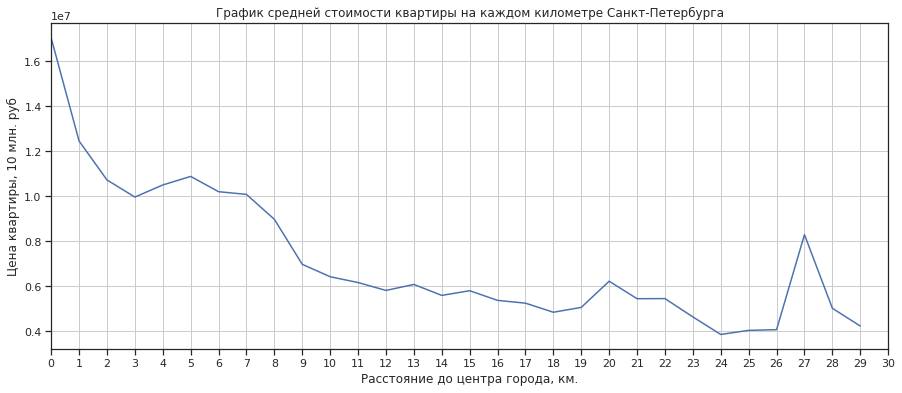

In [122]:
spb_pivot = spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')
plt.figure(figsize=(15,6))
sns.lineplot(x=spb_pivot.index, y=spb_pivot['last_price'])
plt.ylabel(cols_descr_dict.get('last_price'))
plt.xlabel(cols_descr_dict.get('cityCenters_nearest_km'))
plt.xticks(np.arange(0,31,1))
plt.title('График средней стоимости квартиры на каждом километре Санкт-Петербурга')
plt.xlim(0,30)
plt.show()

Квартиры в центре Санкт-Петербурга в среднем стоят значительно дороже, чем в остальной части города.

В самом-самом центре, квартиры стоят в среднем 16 млн. руб. и очень быстро дешевеют, при удалении от него. Уже после первого километра средняя стоимость квартиры составляет 11 млн. руб. За красивый вид из окна приходится очень дорого платить, а в центре Санкт-Петербурга очень красивый вид! Самая низкая стоимость квартир на 24 километре от центра, она в среднем равна 4 млн. руб.. На 27 километре квартиры резко дорожают, до 8 млн. руб. в среднем, скорее всего там находится элитный ЖК или квартал.

In [123]:
columns_report = ['last_price','total_area','living_area','kitchen_area', 'rooms', 'ceiling_height',
                    'floor', 'floors_total', 'balcony', 'days_exposition']

report_table = final_data[columns_report]

In [124]:
index = ['median','max', 'min']
report_pivot_table = pd.DataFrame(index=index, columns=columns_report)
report_pivot_table.loc['median'] = report_table.median(numeric_only=True)
report_pivot_table.loc['max'] = report_table.max(numeric_only=True)
report_pivot_table.loc['min'] = report_table.min(numeric_only=True)

#### 4.6. Вывод по исследовательской части проекта

In [125]:
report_pivot_table

,last_price,total_area,living_area,kitchen_area,rooms,ceiling_height,floor,floors_total,balcony,days_exposition
median,4650000.0,52.0,30.0,9.0,2.0,2.65,4.0,9.0,0.0,107.0
max,35500000.0,199.2,164.7,65.0,11.0,4.8,33.0,60.0,5.0,1580.0
min,720000.0,15.0,2.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0


В данной части проекта мы подробно исследовали общие параметры квартиры по всему датасету: стоимость квартиры, общую площадь, жилую площадь, площадь кухни, количество комнат, этаж, категорию этажа, картографические данные квартиры и время до снятия объявления с площадки. Медианные, максимальные и минимальные значения параметров по всему датасету представлены в таблицы report_table.

Чаще всего в датасете представлены квартиры площадью 40-45 кв. метров, с жилой площадью порядка 18 кв. метров, кухней 8-10 кв. метров, одной-двумя комнатами, находящиеся на этаже со второго по предпоследний, в пяти, девяти или двенадцатиэтажном доме, с высотой потолка около 2.65 метров. При этом чаще всего эти квартиры расположены очень близко к паркам, в 6-12 км. от центра и 20-40 км. от аэропорта. Чаще всего объявления размещались в будни дни, и находились на площадке в среднем 107 дней. Так же нам удалось подтвердить закономерность для Санкт-Петербурга, чем дальше квартира находится от центра, тем больше вероятность, что у нее будут низкие потолки.

Мы проанализировали признак **days_exposition**, описывающий, сколько дней висело объявление на площадке и пришли к выводу, что слишком быстрыми можно считать продажи, произошедшие быстрее чем за 35 дней, а слишком долгими, которые шли более чем 2 года.

Так же мы исследовали зависимость цены от других параметров квартиры:
1. Зависимость цены от общей площади: между ценой и общей площадью квартиры есть сильная положительная корреляция, чем больше площадь квартиры, тем выше цена.
2. Зависимость цены от жилой площади: между ценой и жилой площадью так же есть сильная положительная корреляция, чем больше жилая площадь квартиры, тем выше ее цена.
3. Зависимость цены от площади кухни: между ценой и площадью кухни зависимость так же существует, чем больше площадь кухни, тем выше цена квартиры.
4. Зависимость цены от категории этажа: четкой зависимости между ценой и категорией этажа нет, однако можно выделить, что квартиры на первом этаже в среднем стоят меньше, чем на других.
5. Зависимость от дня недели размещения объявления: четкой зависимости между ценой и днем недели нет.
6. Зависимость от месяца размещения объявления: четкой зависимости между ценой и месяцем размещения объявления нет.
7. Зависимость от года размещения объявления: четкой зависимости между ценой и годом размещения объявления нет, но можно заметить, что 2014 году квартиры стоили заметно дороже, однако в 2015 году резко подешевели и достигли минимальной средней стоимости в 2017 году. Затем начался постепенный рост стоимости квартиры.

Мы выбрали 10 самых часто встречающихся на площадке городов и среди них нашли самую высокую стоимость квадратного метра и самую низкую:
* Самым дорогим городом является Санкт-Петербург, средняя стоимость квадратного метра в нем равна 111 тыс. руб.
* Самая низкая стоимость квадратного метра у города Выборг, она составляет 58 тыс. руб.

В завершении проекта мы исследовали, как меняется средняя стоимость квартиры в зависимости от ее удаления от центра и выяснили, что квартиры в центре Санкт-Петербурга в среднем стоят значительно дороже, чем в остальной части города.

В самом-самом центре, квартиры стоят в среднем 16 млн. руб. и очень быстро дешевеют, при удалении от него. Уже после первого километра средняя стоимость квартиры составляет 11 млн. руб. За красивый вид из окна приходится очень дорого платить, а в центре Санкт-Петербурга очень красивый вид! Самая низкая стоимость квартир на 24 километре от центра, она в среднем равна 4 млн. руб.. На 27 километре квартиры резко дорожают, до 8 млн. руб. в среднем, скорее всего там находится элитный ЖК или квартал.

### 5. Проверка статистических гипотез

Проверим гипотезу о том, что площадь квартир в Санкт-Петербурге и других городах равны. Эти выборки не зависят друг от друга, у нас нет абсолютной уверенности в том, что их дисперсии равны. Нулевая гипотеза будет утверждать, что средние значения площадей квартиры в Санкт-Петербурге и других городах равны. Альтернативная гипотеза будет утверждать, что средние не равны. Зададимся уровнем значимости 5%.

H0 - средние значения площади квартиры в Санкт-Петербурге и других городах равны

H1 - средние значения площадей не равны

alpha = 5%

In [141]:
spb_square = final_data.query('locality_name == "Санкт-Петербург"')['total_area']
not_spb_square = final_data.query('locality_name != "Санкт-Петербург"')['total_area']

In [138]:
alpha = 0.05
stat, p = scipy.stats.ttest_ind(spb_square, not_spb_square, equal_var=False)

In [139]:
if p > alpha:
    print('Нет достаточных оснований отвергнуть нулевую гипотезу')
else:
    print('Мы получили статистически значимый результат, отвергаем нулевую гипотезу')

Мы получили статистически значимый результат, отвергаем нулевую гипотезу


В результате мы получили статистически значимый результат и отвергаем нулевую гипотезу. Принимаем альтернативную гипотезу, средние значения выборок не равны. Проверим:

In [140]:
print(spb_square.mean())
print(not_spb_square.mean())

61.37899341292713
51.458506101837564


Действительно, значения довольно далеко находятся друг от друга.

В результате проверки стат. гипотезы о равенстве средних значений площади квартиры в Санкт-Петербурге и других городах, мы получили статистически значимый результат. **Мы отвергли нулевую гипотезу и приняли альтернативную гипотезу, это значит, что если бы мы утверждали, что средние значения площадей квартир Санкт-Петербурга и остальных городов равны, мы бы ошибались в 95% случаев.**

### 6. Общий вывод

На первом этапе проекта мы проанализировали общую информацию о предоставленном датасете. Данные дают нам довольно обширную информацию об объявлениях на площадке по продаже квартир, начиная от площади квартиры, кухни, цены, заканчивая наличием и расстоянием до парков, аэропортов и водоемов.

В результате беглого просмотра данных мы получили общие представления о датасете, выяснили, что данные довольно разнородны и среди них встречаются объявления о продажах квартир разного класса из разных населенных пунктов.

Так же мы обнаружили некоторые проблемы датасета, изучением и устранением которых займемся в следующем пункте:
1. Большое количество пропусков во множестве столбцов
2. Неявные дубликаты в столбце **locality_name**
3. Аномальные значения, которые явно выбиваются из логики (высота потолка 1 метр или 100 метров)
4. Типы данных некоторых столбцов были присвоены интерпетатором неправильно, их необходимо изменить вручную

Изучив гистограммы распределения данных, мы можем сделать вывод, что в нашем датасете больше всего квартир из пяти/девятиэтажных домов, с потолками 2,5-2,8 метра, 1/2/3 комнатами. Так же имеет место быть сильная корреляция между жилой площадью, ценой и количеством комнат.

После изучения общей информации о датасете мы приступили к устранению проблем датасета: пропусков, дубликатов и аномальных значений. Так же расчитали новые признаки для квартир. 

На первом этапе предобработки данных мы обрабатывали пропущенные значения в 14 столбцах датасета, заполняя их медианными значениями по группам, удаляя или исправляя. На втором этапе предобработки мы изменили типы данных столбцов:

На третьем этапе предобработки данных мы искали повторяющиеся значения в названиях населенных пунктов, нам удалось найти дубликаты, в основном связанные с разным написанием уточнения к населенному пункту, например: городской поселок и поселок городского типа.

На четвертом этапе предобработки мы искали аномальные значения, отлавливали ошибки, которые можно исправить и избавлялись от редких и выбивающихся значений. Нам удалось найти несколько ошибок в высоте потолка, почистить эти значения и исправить, исправить маленькую цену на жилье, а так же отсечь выбивающиеся значения. Так же мы обнаружили большое количество объявлений, которые были сняты на 45 и 60 день, мы удалили эти значения, т.к. посчитали, что они были сняты автоматически.

В результате предобработки данных мы избавились от 8.42%, причем самое большое удаление данных пришлось на удаление аномальных значений в столбце **days_exposition**.

В исследовательской части проекта мы подробно исследовали общие параметры квартиры по всему датасету: стоимость квартиры, общую площадь, жилую площадь, площадь кухни, количество комнат, этаж, категорию этажа, картографические данные квартиры и время до снятия объявления с площадки. Медианные, максимальные и минимальные значения параметров по всему датасету представлены в таблицы report_table.

Чаще всего в датасете представлены квартиры площадью 40-45 кв. метров, с жилой площадью порядка 18 кв. метров, кухней 8-10 кв. метров, одной-двумя комнатами, находящиеся на этаже со второго по предпоследний, в пяти, девяти или двенадцатиэтажном доме, с высотой потолка около 2.65 метров. При этом чаще всего эти квартиры расположены очень близко к паркам, в 6-12 км. от центра и 20-40 км. от аэропорта. Чаще всего объявления размещались в будни дни, и нходились на площадке в среднем 107 дней. Так же нам удалось подтвердить закономерность для Санкт-Петербурга, чем дальше квартира находится от центра, тем больше вероятность, что у нее будут низкие потолки.

Мы проанализировали признак **days_exposition**, описывающий, сколько дней висело объявление на площадке и пришли к выводу, что слишком быстрыми можно считать продажи, произошедшие быстрее чем за 35 дней, а слишком долгими, которые шли более чем 2 года.

Так же мы исследовали зависимость цены от других параметров квартиры и обнаружили, что в датасете присутствует зависимость цены от площади квартиры, количества комнат и отсутствует зависимость от даты публикации и этажа квартиры.

Мы выбрали 10 самых часто встречающихся на площадке городов и среди них нашли самую высокую стоимость квадратного метра и самую низкую:
* Самым дорогим городом является Санкт-Петербург, средняя стоимость квадратного метра в нем равна 111 тыс. руб.
* Самая низкая стоимость квадратного метра у города Выборг, она составляет 58 тыс. руб.

В завершении проекта мы исследовали, как меняется средняя стоимость квартиры в зависимости от ее удаления от центра и выяснили, что квартиры в центре Санкт-Петербурга в среднем стоят значительно дороже, чем в остальной части города.

В самом-самом центре, квартиры стоят в среднем 16 млн. руб. и очень быстро дешевеют, при удалении от него. Уже после первого километра средняя стоимость квартиры составляет 11 млн. руб. За красивый вид из окна приходится очень дорого платить, а в центре Санкт-Петербурга очень красивый вид! Самая низкая стоимость квартир на 24 километре от центра, она в среднем равна 4 млн. руб.. На 27 километре квартиры резко дорожают, до 8 млн. руб. в среднем, скорее всего там находится элитный ЖК или квартал.